In [1]:
# 🔧 Setup and Imports

import sys
from pathlib import Path

# Add project root to Python path
project_root = Path.cwd().parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

In [2]:
import numpy as np
import time
from typing import Literal

# MAPP package imports
from mapp.data.simulate_auction_data import simulate_experiment_data
from mapp.methods.cdf_based.rde_trainer import train_rde_model
from mapp.methods.myerson_net_trainer import train_myerson_net_model
from mapp.experiments.run_experiments import run_experiments
from mapp.utils.plot import plot_kfold_sensitivity, plot_regret_histograms

print("✅ MAPP package loaded successfully")

✅ MAPP package loaded successfully


# MAPP Simulation Workflow

This notebook demonstrates the complete workflow for testing pricing methods on simulated auction data.

**Workflow Steps:**
1. Generate test data (cached)
2. Train RDE and MyersonNet models (cached)
3. Run all pricing methods across parameter grid
4. Analyze and visualize results

**Experimental Design:**
- Test 4 distribution families (truncnorm, truncexpon, beta, truncpareto)
- Vary bids per auction: [10, 50, 100, 200] (data sparsity)
- Vary K-folds: [2, 5, 10] (leave-one-group-out splitting)
- Total: 4 distributions × 4 bids × 3 K-folds = 48 experiments

**Research Questions:**
- How does data sparsity (bids per auction) affect method performance?
- How does leave-one-group-out splitting (K-folds) affect results?
- Do methods behave differently under different (bids, K) combinations?

**Pricing Methods:**
- **eCDF**: Empirical CDF from observed bids
- **KDE**: Kernel Density Estimation
- **RDE**: Repeated Density Estimation (FPCA-based, requires training)
- **Myerson**: Myerson auction mechanism (convex hull method)
- **MyersonNet**: Neural network-based optimal auction mechanism

**Key Concepts:**
- **Regret**: Revenue lost compared to ideal pricing (lower is better)
- **Leave-one-group-out (K-folds)**: Ensures incentive compatibility (truthful bidding)
- **Data sparsity**: Number of bids available for CDF estimation

**Configuration:**
- All value and optimization bounds are configured in `mapp/utils/constants.py`
- Change `VALUE_LOWER_BOUND`, `VALUE_UPPER_BOUND`, `OPTIMIZATION_LOWER_BOUND`, `OPTIMIZATION_UPPER_BOUND` there
- This ensures consistent bounds across all experiments and methods

In [3]:
# 📊 Experiment Configuration
# Distributions to test
DIST_NAMES: list[Literal["truncnorm", "truncexpon", "beta", "truncpareto"]] = [
    "truncnorm",
    "truncexpon",
    "beta",
    "truncpareto",
]

# Test data configuration
N_RUNS = 1000
N_AUCTIONS = 200
BIDS_PER_AUCTION = [10, 50, 100, 200]
TEST_SEED = 0
K_FOLDS = [2, 5, 10]


# RDE training configurations
RDE_CONFIGS = [(200, 20), (20, 200), (200, 200)]  # (N_train, n_train)

# MyersonNet training configurations
# Train models for ALL unique group sizes (perfect match, no truncation/padding)
MYERSONNET_CONFIGS = [
    (200, 200, 2),  # Groups of 2: 10 bids/k=5 → 20,000 samples
    (200, 200, 5),  # Groups of 5: 10/k=2, 50/k=10 → 8,000 samples
    (200, 200, 10),  # Groups of 10: 50/k=5, 100/k=10 → 4,000 samples
    (200, 200, 20),  # Groups of 20: 100/k=5, 200/k=10 → 2,000 samples
    (200, 200, 25),  # Groups of 25: 50/k=2 → 1,600 samples
    (200, 200, 40),  # Groups of 40: 200/k=5 → 1,000 samples
    (200, 200, 50),  # Groups of 50: 100/k=2 → 800 samples
    (200, 200, 100),  # Groups of 100: 200/k=2 → 400 samples
]
MYERSONNET_EPOCHS = 50000  # Training epochs for MyersonNet

# Determine training data requirements
TRAIN_AUCTIONS = max(
    max(N for N, n in RDE_CONFIGS), max(N for N, n, _ in MYERSONNET_CONFIGS)
)
TRAIN_BIDS_PER_AUCTION = max(
    max(n for N, n in RDE_CONFIGS), max(n for N, n, _ in MYERSONNET_CONFIGS)
)
TRAIN_SEED = 9999

total_configs = len(BIDS_PER_AUCTION) * len(K_FOLDS)
total_experiments = len(DIST_NAMES) * total_configs

print(
    f"📊 {len(DIST_NAMES)} dists × {len(BIDS_PER_AUCTION)} bids × {len(K_FOLDS)} K = {len(DIST_NAMES)*len(BIDS_PER_AUCTION)*len(K_FOLDS)} experiments"
)

📊 4 dists × 4 bids × 3 K = 48 experiments


## Step 1: Generate Test Data

Generate test auction data for each distribution. Data is automatically cached to avoid regeneration.

**Data Generation:**
- 4 distributions × 200 bids (max) = 4 test datasets
- Each dataset: 1000 runs × 200 auctions × 200 bids
- Full data is generated once, then sliced automatically during experiments based on configuration

**Caching:** Files saved to `workspace/{dist_name}/data/` with naming pattern:
- Format: `{dist}_a{auctions}_b{bids}_r{runs}_s{seed}_test.json`
- Example: `truncnorm_a200_b200_r1000_s0_test.json`
- Subsequent runs load from cache unless you use `force_regenerate=True`

In [4]:
# 📦 Step 1: Generate Test Data (Cached)

print("=" * 60)
print("STEP 1: Generating Test Data")
print("=" * 60)

test_datasets = {}

for dist_name in DIST_NAMES:
    data = simulate_experiment_data(
        dist_name=dist_name,
        purpose="test",
        n_auctions=N_AUCTIONS,
        bids_per_auction=max(BIDS_PER_AUCTION),
        n_runs=N_RUNS,
        seed=TEST_SEED,
    )
    test_datasets[dist_name] = data
    print(f"✅ {dist_name.upper()}: {len(data)} runs × {len(data[0])} auctions")

print(f"\n{'=' * 60}")
print("✅ All test datasets ready!")
print(f"{'=' * 60}")

STEP 1: Generating Test Data
📂 Loading cached data: truncnorm_a200_b200_r1000_s0_test.json
✅ Loaded 1000 runs × 200 auctions
✅ TRUNCNORM: 1000 runs × 200 auctions
📂 Loading cached data: truncexpon_a200_b200_r1000_s0_test.json
✅ Loaded 1000 runs × 200 auctions
✅ TRUNCEXPON: 1000 runs × 200 auctions
📂 Loading cached data: beta_a200_b200_r1000_s0_test.json
✅ Loaded 1000 runs × 200 auctions
✅ BETA: 1000 runs × 200 auctions
📂 Loading cached data: truncpareto_a200_b200_r1000_s0_test.json
✅ Loaded 1000 runs × 200 auctions
✅ TRUNCPARETO: 1000 runs × 200 auctions

✅ All test datasets ready!


## Step 2: Train RDE and MyersonNet Models

Generate training data and train RDE and MyersonNet models with different configurations. Models are automatically cached.

### RDE (Repeated Density Estimation)

**What is RDE?**
- **Repeated Density Estimation**: FPCA-based method for estimating CDFs from repeated auction data
- Leverages functional data analysis to learn patterns across multiple auctions
- Proposed in the paper as superior to standard methods (eCDF, KDE) for auction pricing
- Requires separate training data (unlike eCDF/KDE which are trained on-the-fly)

**Training Data Generation:**
- 4 distributions × 200×200 training data = 4 training datasets
- Each dataset: 1 run × 200 auctions × 200 bids
- Separate from test data (train seed=9999, test seed=0)
- Training data is denser than test data to enable robust FPCA learning

**RDE Training Configurations (Ablation Study):**
We train 3 models per distribution to test RDE's sensitivity to training data structure:

1. **(200×20)**: 200 auctions × 20 bids each = 4,000 data points
   - **Many auctions, sparse bids per auction**
   - Tests if RDE can learn from many sparse observations
   - ⚠️ Long training time (many auctions → expensive FPCA)
   
2. **(20×200)**: 20 auctions × 200 bids each = 4,000 data points
   - **Few auctions, dense bids per auction**
   - Tests if RDE can learn from few dense observations
   - ✅ Fast training (few auctions → cheap FPCA)
   
3. **(200×200)**: 200 auctions × 200 bids each = 40,000 data points
   - **Many auctions, dense bids per auction**
   - Full training data baseline
   - ⚠️ Longest training time (computational bottleneck)

**Research Question:** Does RDE performance depend more on:
- Number of auctions (repeated observations for FPCA)?
- Number of bids per auction (density of each observation)?
- Total data volume?

### MyersonNet (Neural Network-Based)

**What is MyersonNet?**
- Neural network that learns optimal auction mechanisms from bid data
- Based on ["Optimal Auctions through Deep Learning" (Dütting et al., 2019)](https://arxiv.org/abs/1706.03459)
- Learns virtual valuations and allocation rules to maximize seller revenue
- Uses PyTorch implementation adapted to MAPP framework

**MyersonNet Training Configurations (Perfect Scale Matching):**
We train 8 models per distribution, one for each unique group size in test scenarios:

1. **2 agents**: 200 auctions × 100 samples = 20,000 training samples
   - For: 10 bids, k=5 (groups of 2)
   
2. **5 agents**: 200 auctions × 40 samples = 8,000 training samples
   - For: 10 bids, k=2 (groups of 5) and 50 bids, k=10 (groups of 5)
   
3. **10 agents**: 200 auctions × 20 samples = 4,000 training samples
   - For: 50 bids, k=5 (groups of 10) and 100 bids, k=10 (groups of 10)
   
4. **20 agents**: 200 auctions × 10 samples = 2,000 training samples
   - For: 100 bids, k=5 (groups of 20) and 200 bids, k=10 (groups of 20)
   
5. **25 agents**: 200 auctions × 8 samples = 1,600 training samples
   - For: 50 bids, k=2 (groups of 25)
   
6. **40 agents**: 200 auctions × 5 samples = 1,000 training samples
   - For: 200 bids, k=5 (groups of 40)
   
7. **50 agents**: 200 auctions × 4 samples = 800 training samples
   - For: 100 bids, k=2 (groups of 50)
   
8. **100 agents**: 200 auctions × 2 samples = 400 training samples
   - For: 200 bids, k=2 (groups of 100)

**Why All 8 Scales?**
- ✅ **Perfect match**: Each test scenario uses exactly the right model (no padding/truncation)
- ✅ **No information loss**: Uses all available bids in each group
- ✅ **Fair comparison**: MyersonNet sees the same auction structure during training and testing
- ✅ **Comprehensive**: Covers full range from 2-bidder to 100-bidder auctions

**Skipped Scenarios:**
- ⏭️ **10 bids, k=10** (1-bidder groups): No competition, not a valid auction

**Training:** 50,000 epochs with gradient descent for each model

**Model Selection During Testing:**
- Automatically selects the model matching the group size
- Example: 200 bids, k=5 → 40 bids/group → uses 40-agent model

**Caching:** Files saved to `workspace/{dist_name}/` with naming patterns:
- RDE: `rde_models/a{auctions}_b{bids}_s{seed}/{dist}_N{N_train}_n{n_train}_l{lower}_u{upper}.pkl`
- MyersonNet: `myerson_net_models/a{auctions}_b{bids}_s{seed}/{dist}_N{N_train}_n{n_train}_agents{n_agents}_epochs{n_epochs}.pt`
- Subsequent runs load from cache unless you use `force_retrain=True`

**Output:** Trained models stored in:
- `rde_models[dist_name][(N_train, n_train)]` for RDE
- `myerson_net_models[dist_name][(N_train, n_train, n_agents)]` for MyersonNet

**Total Models:**
- RDE: 4 distributions × 3 configs = 12 models
- MyersonNet: 4 distributions × 8 configs = 32 models
- **Grand total: 44 models**

In [5]:
# 🎓 Step 2: Train RDE and MyersonNet Models (Cached)

print("=" * 60)
print("STEP 2: Training RDE and MyersonNet Models")
print("=" * 60)

# Store trained models
rde_models = {}
myerson_net_models = {}

for dist_name in DIST_NAMES:
    print(f"\n{'#' * 60}")
    print(f"# Training models for {dist_name.upper()}")
    print(f"{'#' * 60}")

    # Generate training data (single run, cached)
    train_data = simulate_experiment_data(
        dist_name=dist_name,
        purpose="train",
        n_auctions=TRAIN_AUCTIONS,
        bids_per_auction=TRAIN_BIDS_PER_AUCTION,
        seed=TRAIN_SEED,
    )

    # Extract training bids as 2D array
    train_bids = np.array([auction.bids for auction in train_data[0]])
    print(
        f"📦 Training data: {train_bids.shape[0]} auctions × {train_bids.shape[1]} bids"
    )

    # Train RDE models for each configuration
    print(f"\n{'─' * 60}")
    print("RDE Models")
    print(f"{'─' * 60}")
    rde_models[dist_name] = {}
    for N_train, n_train in RDE_CONFIGS:
        print(f"🔧 Training RDE model: N={N_train}, n={n_train}")

        model = train_rde_model(
            dist_name=dist_name,
            train_bids=train_bids,
            train_seed=TRAIN_SEED,
            N_train=N_train,
            n_train=n_train,
        )

        rde_models[dist_name][(N_train, n_train)] = model
        print("   ✅ Model trained and cached")

    # Train MyersonNet models for each configuration
    print(f"\n{'─' * 60}")
    print("MyersonNet Models")
    print(f"{'─' * 60}")
    myerson_net_models[dist_name] = {}
    for N_train, n_train, n_agents in MYERSONNET_CONFIGS:
        print(
            f"🔧 Training MyersonNet model: N={N_train}, n={n_train}, agents={n_agents}"
        )

        model = train_myerson_net_model(
            dist_name=dist_name,
            train_bids=train_bids,
            train_seed=TRAIN_SEED,
            N_train=N_train,
            n_train=n_train,
            n_agents=n_agents,
            n_epochs=MYERSONNET_EPOCHS,
        )

        myerson_net_models[dist_name][(N_train, n_train, n_agents)] = model
        print("   ✅ Model trained and cached")

print(f"\n{'=' * 60}")
print("✅ All models ready!")
print(
    f"   RDE: {len(DIST_NAMES)} distributions × {len(RDE_CONFIGS)} configs = {len(DIST_NAMES) * len(RDE_CONFIGS)} models"
)
print(
    f"   MyersonNet: {len(DIST_NAMES)} distributions × {len(MYERSONNET_CONFIGS)} configs = {len(DIST_NAMES) * len(MYERSONNET_CONFIGS)} models"
)
print(f"{'=' * 60}")

STEP 2: Training RDE and MyersonNet Models

############################################################
# Training models for TRUNCNORM
############################################################
📂 Loading cached data: truncnorm_a200_b200_r1_s9999_train.json
✅ Loaded 1 runs × 200 auctions
📦 Training data: 200 auctions × 200 bids

────────────────────────────────────────────────────────────
RDE Models
────────────────────────────────────────────────────────────
🔧 Training RDE model: N=200, n=20
📂 Loading cached RDE model: a200_b200_s9999/truncnorm_N200_l1_n20_u10.pkl
✅ Loaded RDE model
   (train: 200×200, used: 200×20)
   ✅ Model trained and cached
🔧 Training RDE model: N=20, n=200
📂 Loading cached RDE model: a200_b200_s9999/truncnorm_N20_l1_n200_u10.pkl
✅ Loaded RDE model
   (train: 200×200, used: 20×200)
   ✅ Model trained and cached
🔧 Training RDE model: N=200, n=200
📂 Loading cached RDE model: a200_b200_s9999/truncnorm_N200_l1_n200_u10.pkl
✅ Loaded RDE model
   (train: 200×200, us

## Step 3: Run Experiments

Run all pricing methods on the test data and collect regret statistics.

**Methods Tested (7 total):**
- **Base methods (3)**: eCDF, KDE, Myerson
- **RDE variants (3)**: Different training data configurations
  - **RDE (200×20)**: Trained on many sparse auctions
  - **RDE (20×200)**: Trained on few dense auctions
  - **RDE (200×200)**: Trained on full data
- **MyersonNet (1)**: Neural network-based pricing with automatic model selection
  - Automatically selects from 8 trained models based on group size
  - Perfect scale match for each test scenario (no padding/truncation)

**MyersonNet Model Selection:**
```
Group size 2   → uses 2-agent model
Group size 5   → uses 5-agent model
Group size 10  → uses 10-agent model
Group size 20  → uses 20-agent model
Group size 25  → uses 25-agent model
Group size 40  → uses 40-agent model
Group size 50  → uses 50-agent model
Group size 100 → uses 100-agent model
```

**Experimental Setups:**
- 4 distributions (truncnorm, truncexpon, beta, truncpareto)
- 4 bid counts: [10, 50, 100, 200]
- 3 K-folds: [2, 5, 10]
- **Total setups**: 48 experimental configurations

**MyersonNet Coverage:**
- ✅ Runs on 47 of 48 configurations (perfect scale match)
- ⏭️ Skips: 10 bids, k=10 (1-bidder groups - no competition)

**Experimental Design:**
- **Each setup tests 7 methods** (6 for 1-bidder case)
- **Total experiments**: ~336 experiments
- Each experiment: 1000 runs × 200 auctions
- Data slicing handled automatically by `run_experiments()` based on `n_auctions` and `bids_per_auction` parameters
- Leave-one-group-out (varying K) ensures incentive compatibility
- Regret = Ideal Revenue - Method Revenue (lower is better)

**Research Questions:**
- How does data sparsity (bids per auction) affect method performance?
- How does leave-one-group-out splitting (K-folds) affect results?
- Do methods behave differently under different (bids, K) combinations?
- Which RDE training configuration performs best across different test scenarios?
- How does MyersonNet performance vary across different auction scales (2 to 100 bidders)?
- Does MyersonNet benefit from scale-specific training?
- How does neural network-based MyersonNet compare to traditional methods?

**Automatic Checkpointing & Resume:**
- Each experiment saves progress every 100 runs to: `workspace/{dist}/regrets/{dist}_b{bids}_k{K}_{method}.pkl`
- If crash occurs at run 500/1000, automatically resumes from run 500 on restart
- Completed experiments are skipped entirely (loaded from cache)
- No manual intervention needed - just re-run the notebook

**Parallelization:**
- Set `N_JOBS_EXPERIMENTS = 1` for sequential execution (default)
- Set `N_JOBS_EXPERIMENTS = 4` to use 4 CPU cores
- Set `N_JOBS_EXPERIMENTS = -1` to use all available CPU cores

In [ ]:
# 🔬 Step 3: Run Experiments for All Methods

print("=" * 60)
print("STEP 3: Running Pricing Method Experiments")
print("=" * 60)

# Build list of all methods to test
methods_to_test = []

# Base methods
for method in ["ecdf", "kde", "myerson"]:
    methods_to_test.append({"name": method, "method": method, "kwargs": {}})

# RDE methods with different training configs
for N_train, n_train in RDE_CONFIGS:
    methods_to_test.append(
        {
            "name": f"RDE ({N_train}×{n_train})",
            "method": "rde",
            "slug": f"rde_{N_train}x{n_train}",
            "kwargs": {"rde_model": None},  # Will be set per distribution
        }
    )

# MyersonNet - add as a single method, model selection happens per (bids, k)
methods_to_test.append(
    {
        "name": "MyersonNet",
        "method": "myerson_net",
        "slug": "myersonnet",
        "kwargs": {"model": None},  # Will be selected based on group size
    }
)

# Calculate totals
total_configs = sum(len([k for k in K_FOLDS if k <= bids]) for bids in BIDS_PER_AUCTION)
total_setups = len(DIST_NAMES) * total_configs
total_methods = len(methods_to_test)
total_experiments = total_setups * total_methods

print(
    f"Total: ~{total_experiments} experiments ({total_setups} setups × {total_methods} methods)"
)
print("Note: MyersonNet skips scenarios with <2 bidders per group")
print()

# Run experiments
CHECKPOINT_RUNS = 100  # Checkpoint every N runs within each experiment
N_JOBS_EXPERIMENTS = -1  # Set to 4 or -1 for parallel execution
all_results = {}
config_count = 0
start_time = time.time()

for dist_name in DIST_NAMES:
    print(f"{'#' * 60}\n# {dist_name.upper()}\n{'#' * 60}")

    all_results[dist_name] = []
    test_data = test_datasets[dist_name]

    # Loop through 2D grid: (bids, K)
    for bids_per_auction in BIDS_PER_AUCTION:
        for k in [k for k in K_FOLDS if k <= bids_per_auction]:
            config_count += 1
            group_size = bids_per_auction // k
            print(
                f"\nSetup {config_count}/{total_setups}: {bids_per_auction} bids × K={k} (groups of {group_size})"
            )

            # Test all methods on this configuration
            for method_config in methods_to_test:
                method_name = method_config["name"]
                method_slug = method_config.get("slug", method_config["method"])

                # Initialize MyersonNet-specific variables (to avoid "possibly unbound" errors)
                method_name_with_agents = method_name
                method_slug_with_agents = method_slug

                # Skip MyersonNet if group size < 2 (only happens for 10 bids, k=10)
                if method_config["method"] == "myerson_net" and group_size < 2:
                    print(f"  ⏭️  {method_name}... SKIPPED (1-bidder groups)")
                    continue

                # Set RDE model if needed
                kwargs = method_config["kwargs"].copy()
                if method_config["method"] == "rde":
                    N_train, n_train = [
                        (N, n)
                        for N, n in RDE_CONFIGS
                        if f"RDE ({N}×{n})" == method_name
                    ][0]
                    kwargs["rde_model"] = rde_models[dist_name][(N_train, n_train)]

                # Set MyersonNet model - select based on group size
                elif method_config["method"] == "myerson_net":
                    # Find model that matches group size exactly
                    matching_configs = [
                        (N, n, a) for N, n, a in MYERSONNET_CONFIGS if a == group_size
                    ]

                    if matching_configs:
                        N_train, n_train, n_agents = matching_configs[0]
                        kwargs["model"] = myerson_net_models[dist_name][
                            (N_train, n_train, n_agents)
                        ]
                        method_name_with_agents = f"MyersonNet ({n_agents}a)"
                        method_slug_with_agents = f"myersonnet_{n_agents}a"
                    else:
                        # Should not happen with our configuration
                        print(
                            f"  ⚠️  {method_name}... ERROR: No model for group_size={group_size}"
                        )
                        continue

                # Run experiment (handles caching/checkpointing internally)
                print(
                    f"  🔧 {method_name_with_agents if method_config['method'] == 'myerson_net' else method_name}...",
                    end=" ",
                    flush=True,
                )
                result = run_experiments(
                    experiment_data=test_data,
                    method=method_config["method"],
                    n_auctions=N_AUCTIONS,
                    bids_per_auction=bids_per_auction,
                    k=k,
                    n_jobs=N_JOBS_EXPERIMENTS,
                    dist_name=dist_name,
                    method_slug=(
                        method_slug_with_agents
                        if method_config["method"] == "myerson_net"
                        else method_slug
                    ),
                    checkpoint_every=CHECKPOINT_RUNS,
                    **kwargs,
                )

                # Add metadata
                result["method"] = (
                    method_name_with_agents
                    if method_config["method"] == "myerson_net"
                    else method_name
                )
                result["bids_per_auction"] = bids_per_auction
                result["k"] = k
                all_results[dist_name].append(result)

                print(f"mean={np.mean(result['regrets']):.4f}")

# Summary
elapsed_time = time.time() - start_time
total_completed = sum(len(all_results[d]) for d in DIST_NAMES)

print(f"\n{'=' * 60}")
print(f"✅ Complete! {total_completed} experiments")
print(f"   Time: {elapsed_time:.1f}s ({elapsed_time/60:.1f} min)")
print(f"{'=' * 60}")

## Step 5: Visualize Results

  All results are stored in the `all_results` dictionary for further
  analysis.

  **Data Structure:**
  - `all_results[dist_name]` - Flat list of result dictionaries
  - Each result contains:
    - `method`: Method name ('ecdf', 'kde', 'myerson', 'RDE (200×20)', 'RDE (20×200)', 'RDE (200×200)')
    - `n_runs`: Number of experimental runs (1000)
    - `n_auctions`: Number of auctions per run (200)
    - `bids_per_auction`: Number of bids used (10, 50, 100, or 200)
    - `k`: K-fold value used (2, 5, or 10)
    - `regrets`: List of average regrets per run (length = 1000)
    - `runs_completed`: Number of runs completed (1000)
    - `mean_regret`: Mean regret across all runs (pre-computed)
    - `std_regret`: Standard deviation of regret (pre-computed)

Now let's create visualizations using the plotting utilities to analyze method performance across different configurations.

### 4.1: K-Fold Sensitivity Analysis

Compare how different K-fold values affect performance for a fixed bid count.

✅ Saved: kfold_sensitivity_truncnorm.png (4 subplots: 10, 50, 100, 200 bids)


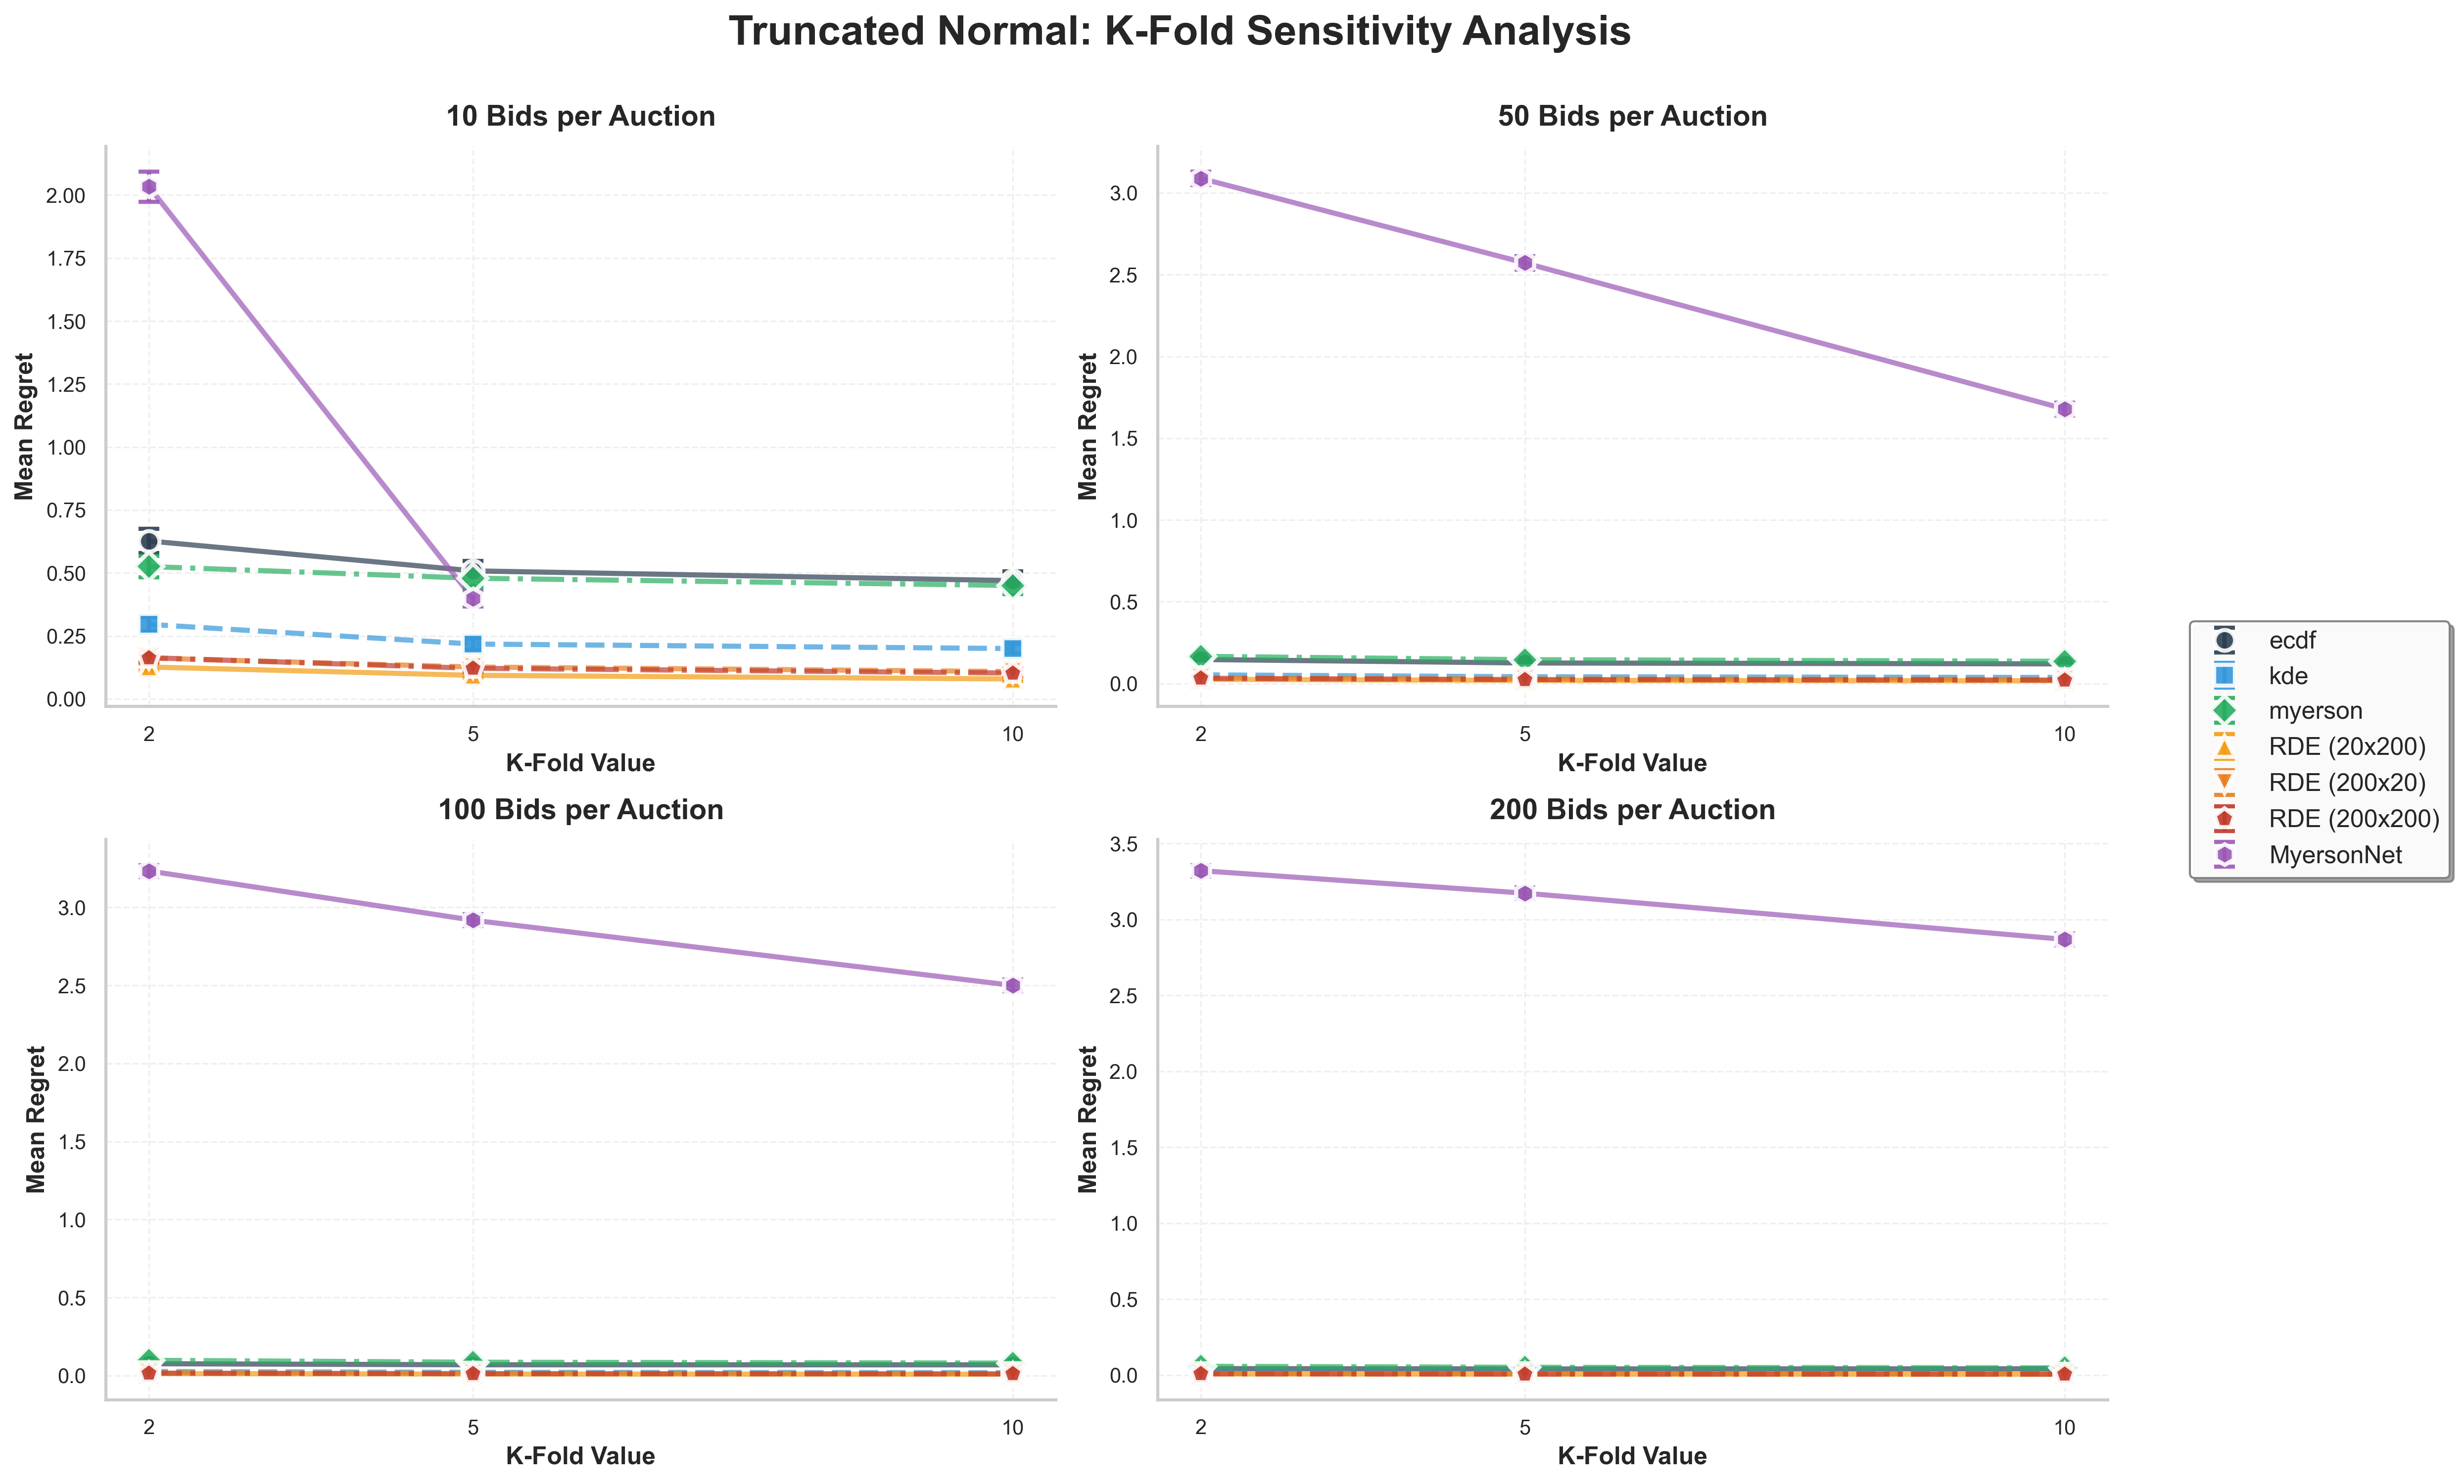

✅ Saved: kfold_sensitivity_truncexpon.png (4 subplots: 10, 50, 100, 200 bids)


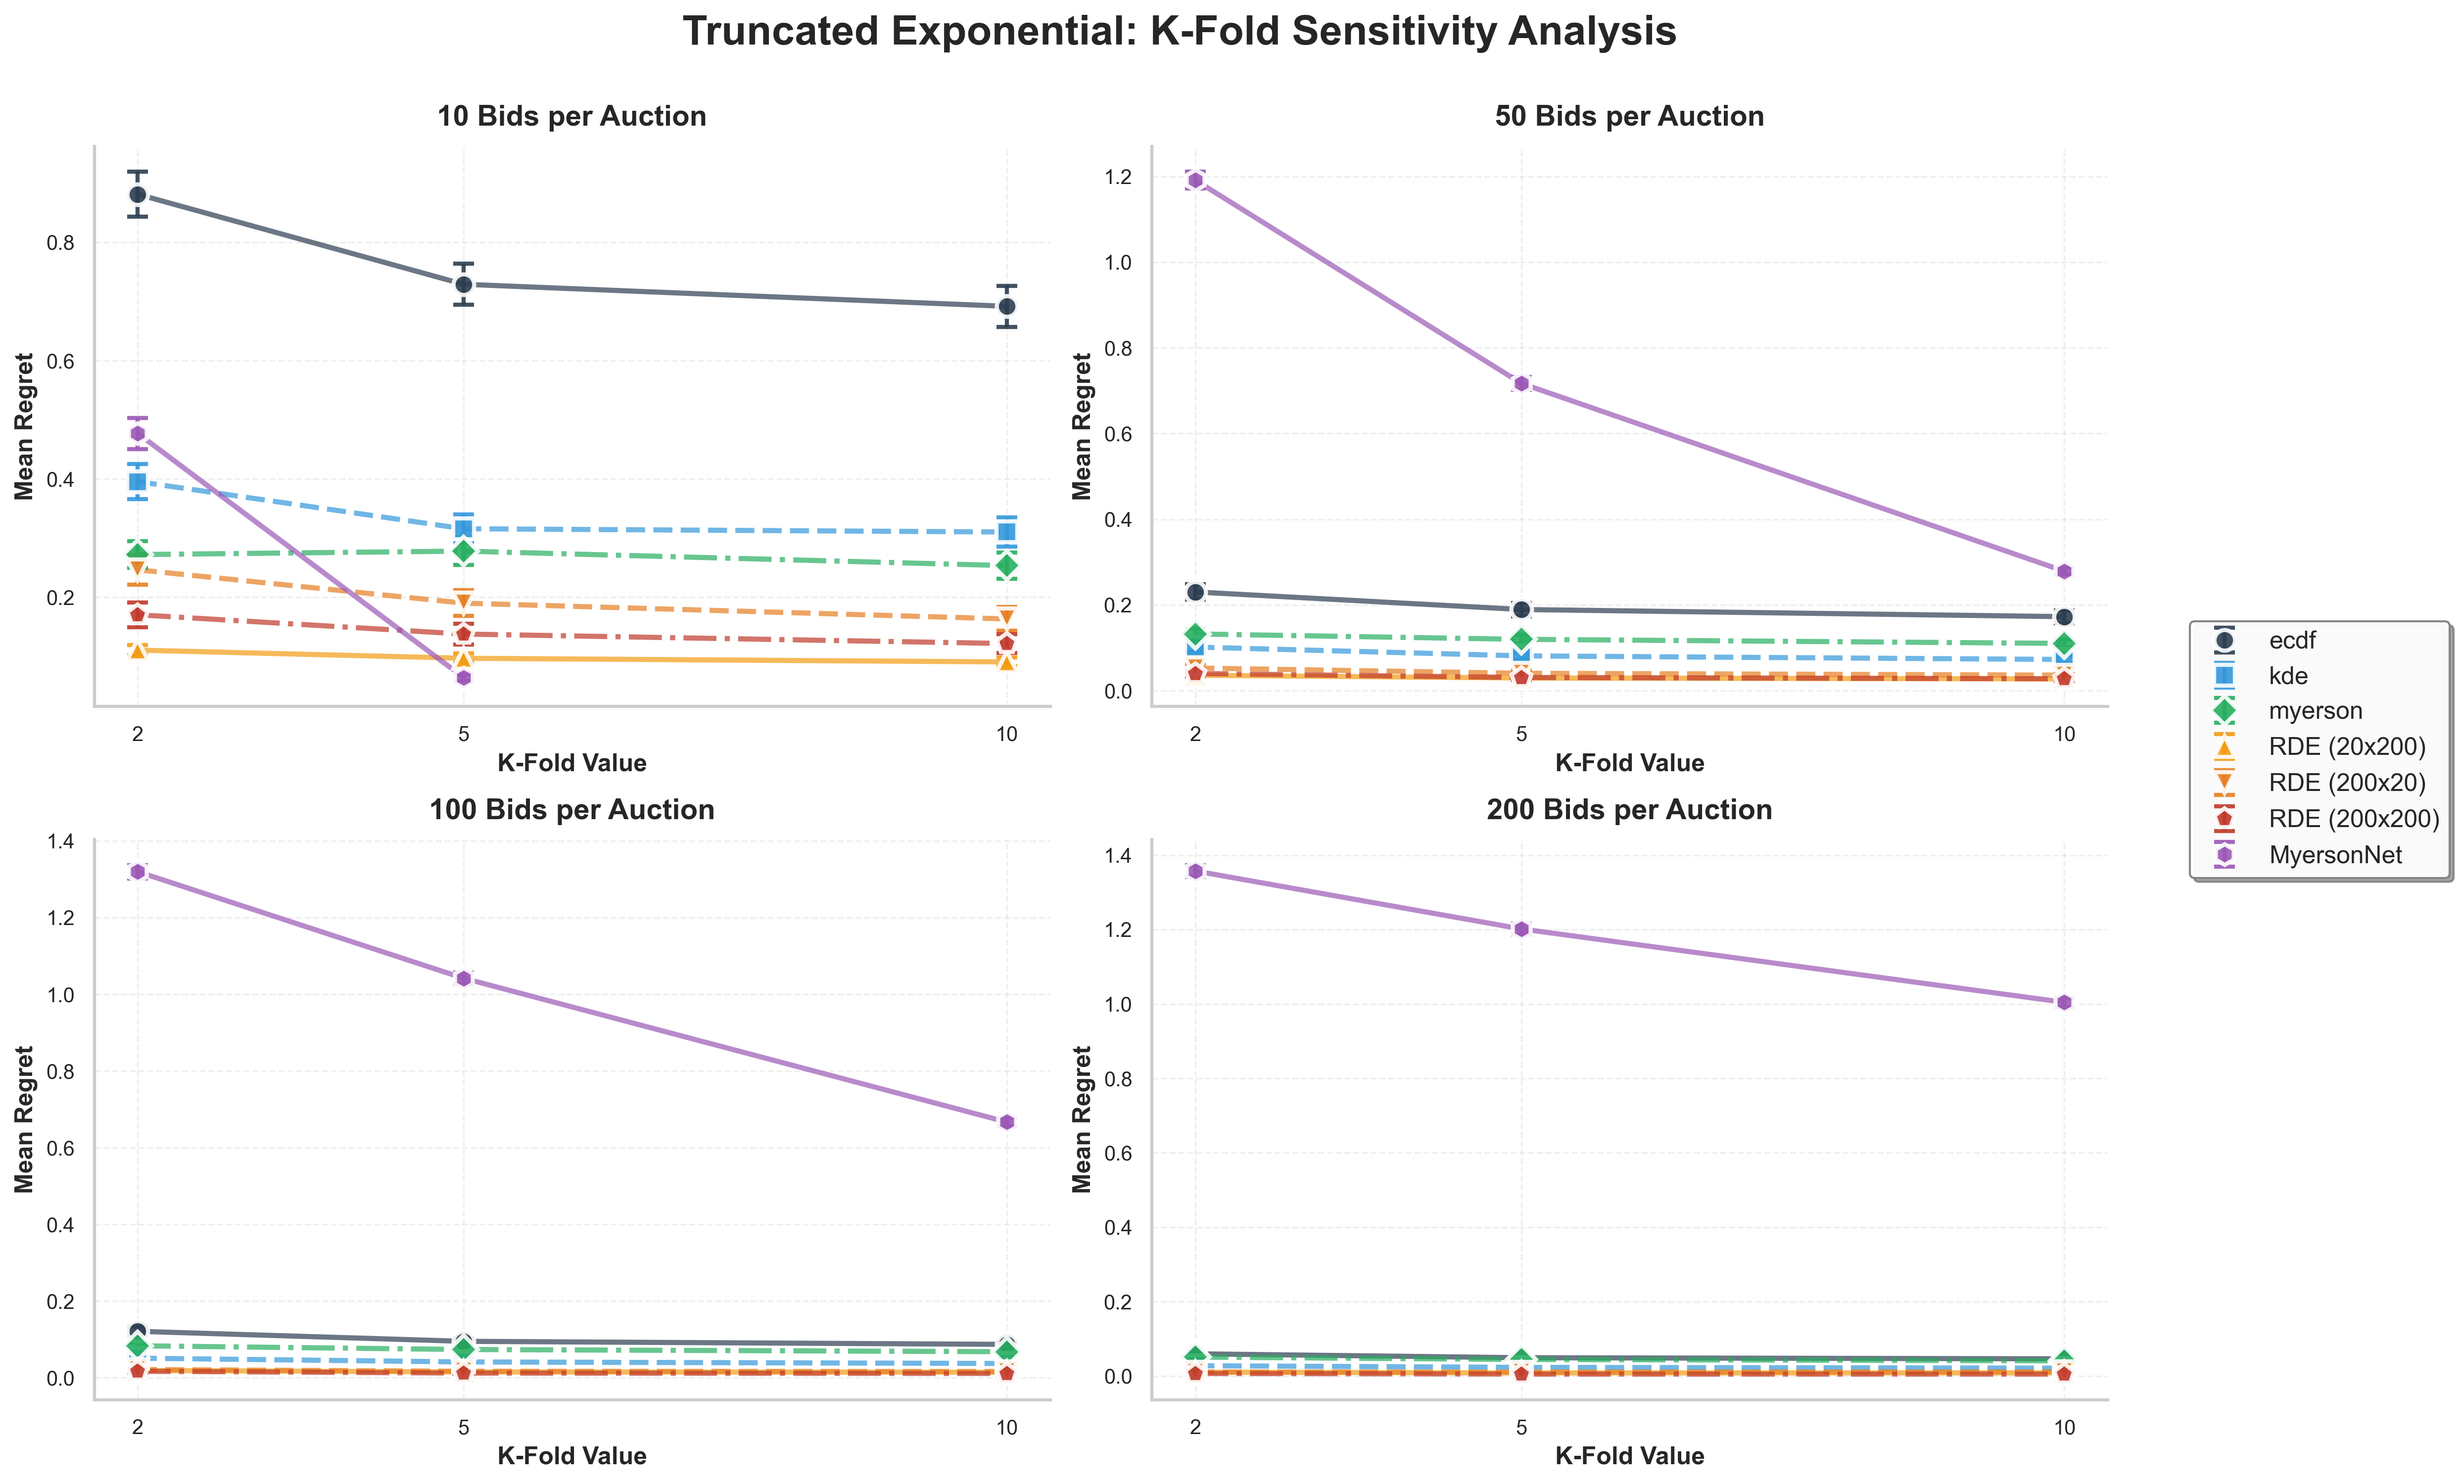

✅ Saved: kfold_sensitivity_beta.png (4 subplots: 10, 50, 100, 200 bids)


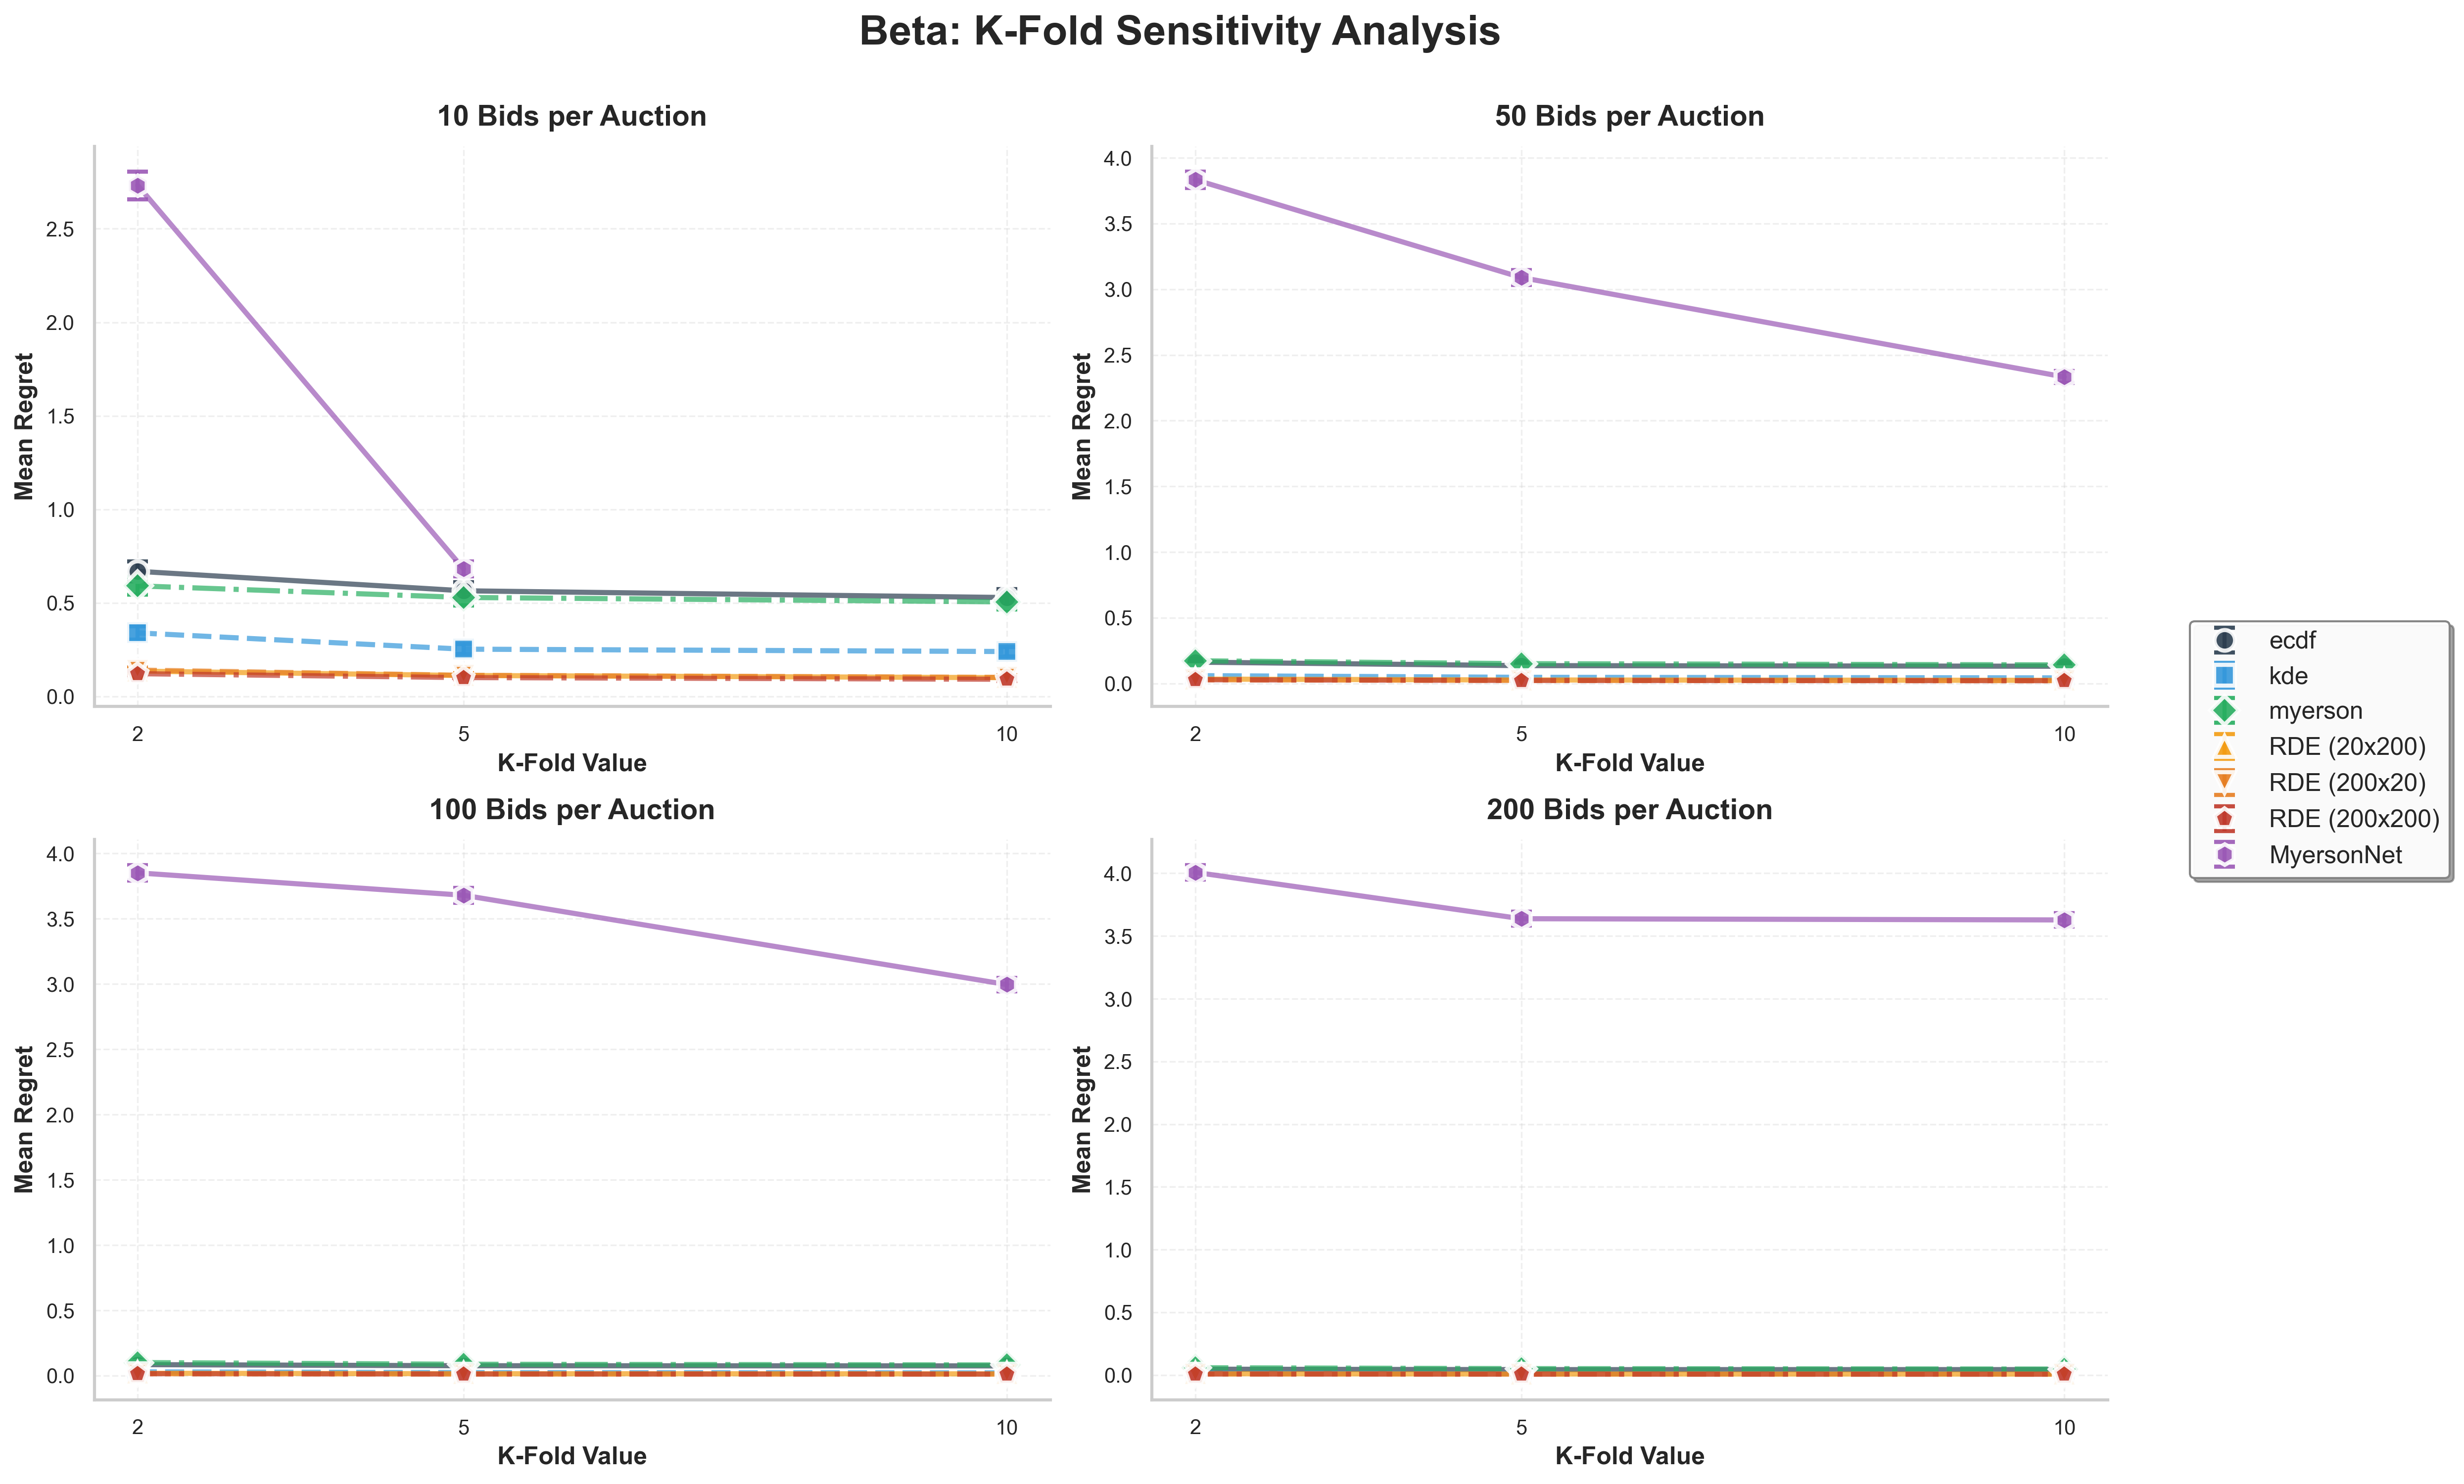

✅ Saved: kfold_sensitivity_truncpareto.png (4 subplots: 10, 50, 100, 200 bids)


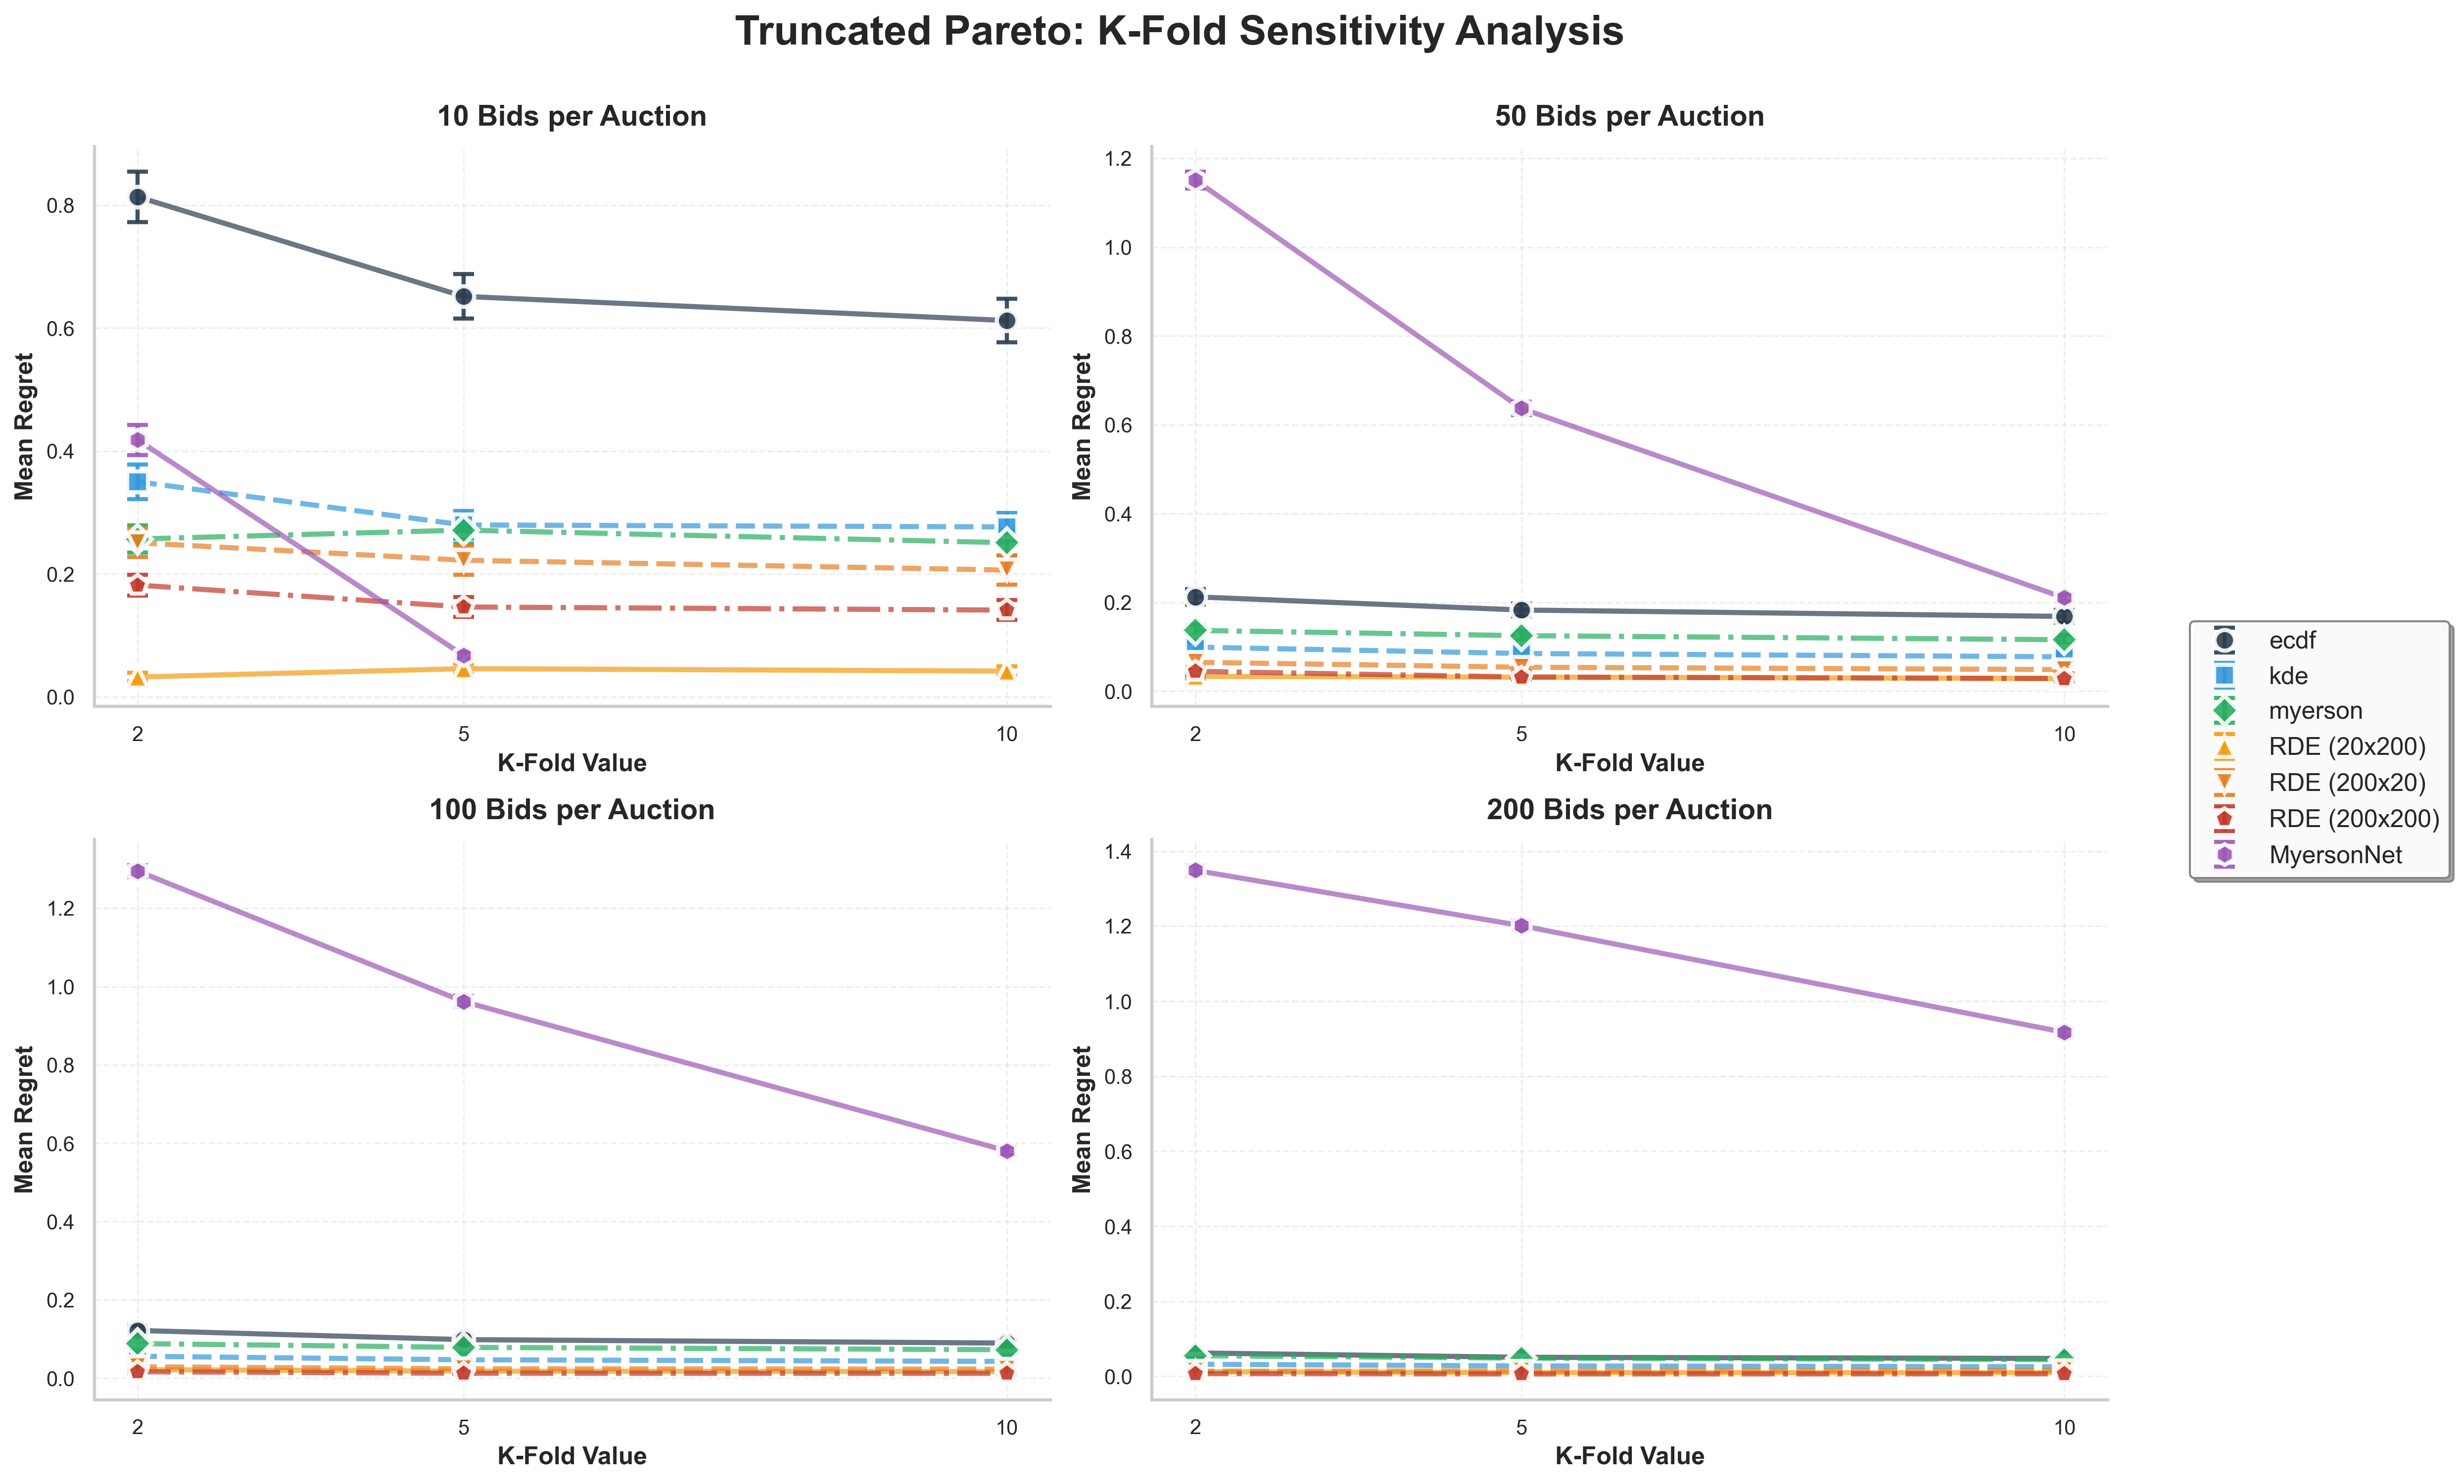

In [4]:
plot_kfold_sensitivity(
    project_root=project_root,
    dist_names=DIST_NAMES,  # type: ignore
    bids_per_auction=BIDS_PER_AUCTION,
    k_folds=K_FOLDS,
    save_dir="workspace/plots/sensitivity",
    show=True,
)

✅ Saved: histogram_truncnorm_k2.png (4 subplots: 10, 50, 100, 200 bids)


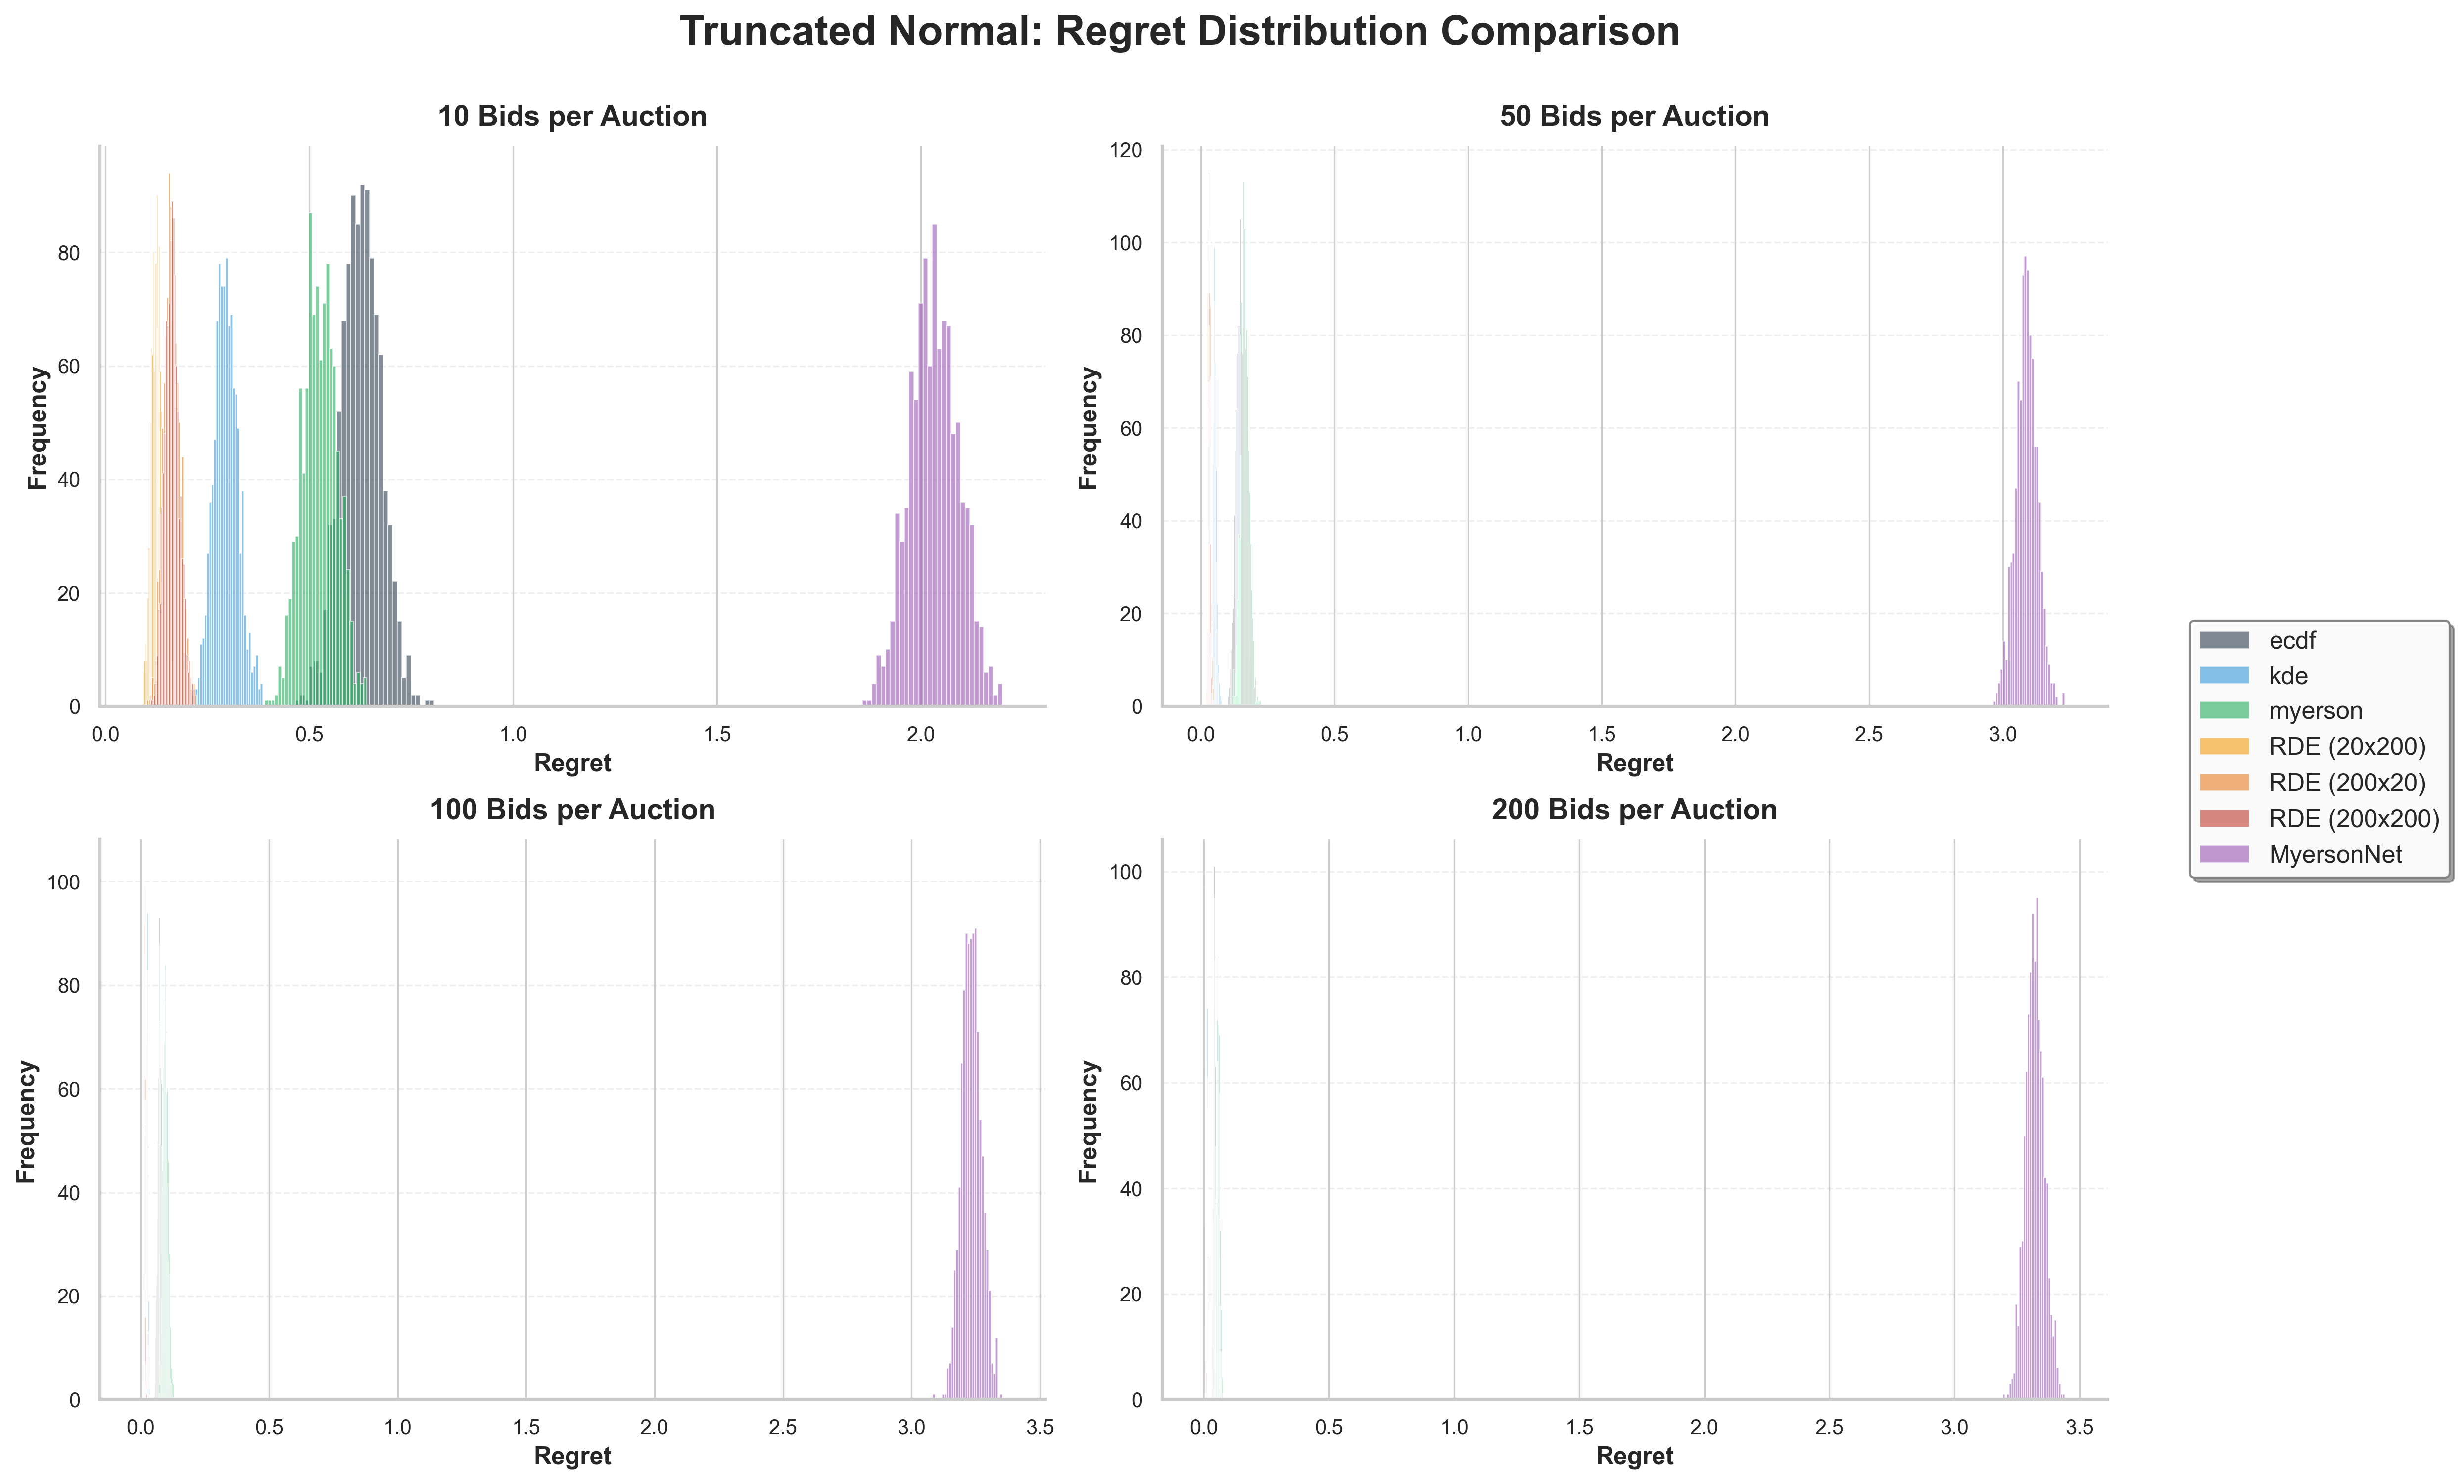

✅ Saved: histogram_truncexpon_k2.png (4 subplots: 10, 50, 100, 200 bids)


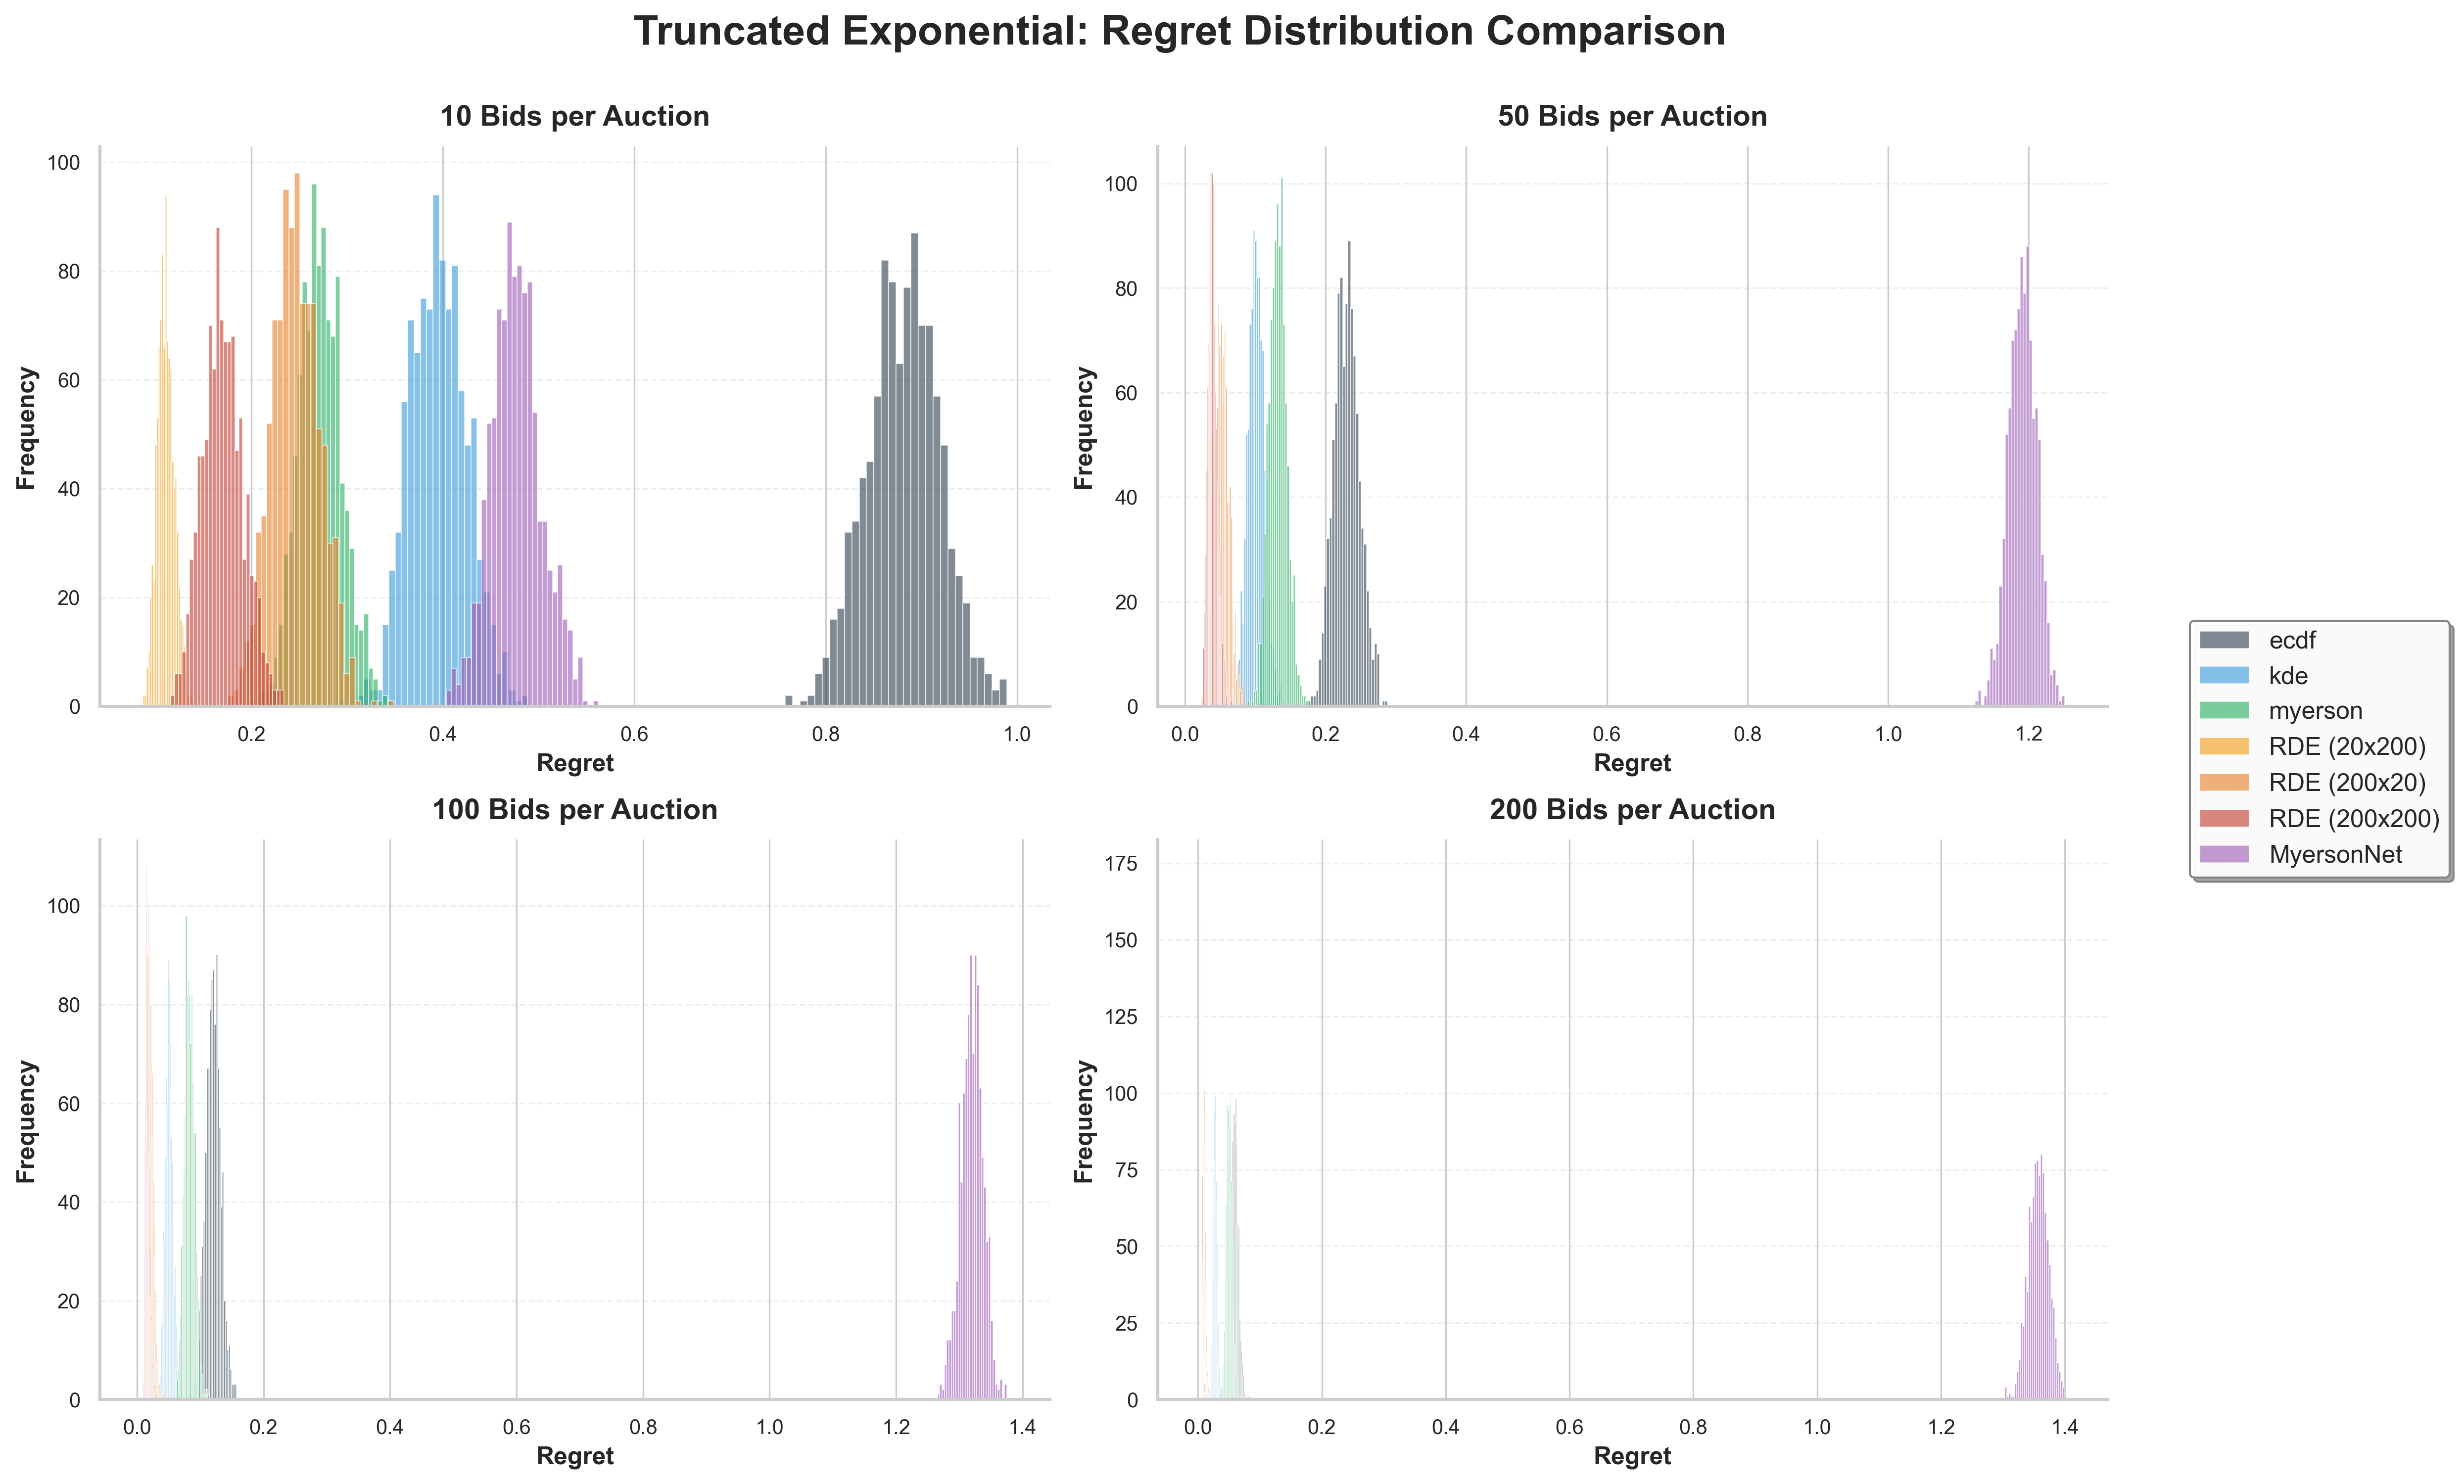

✅ Saved: histogram_beta_k2.png (4 subplots: 10, 50, 100, 200 bids)


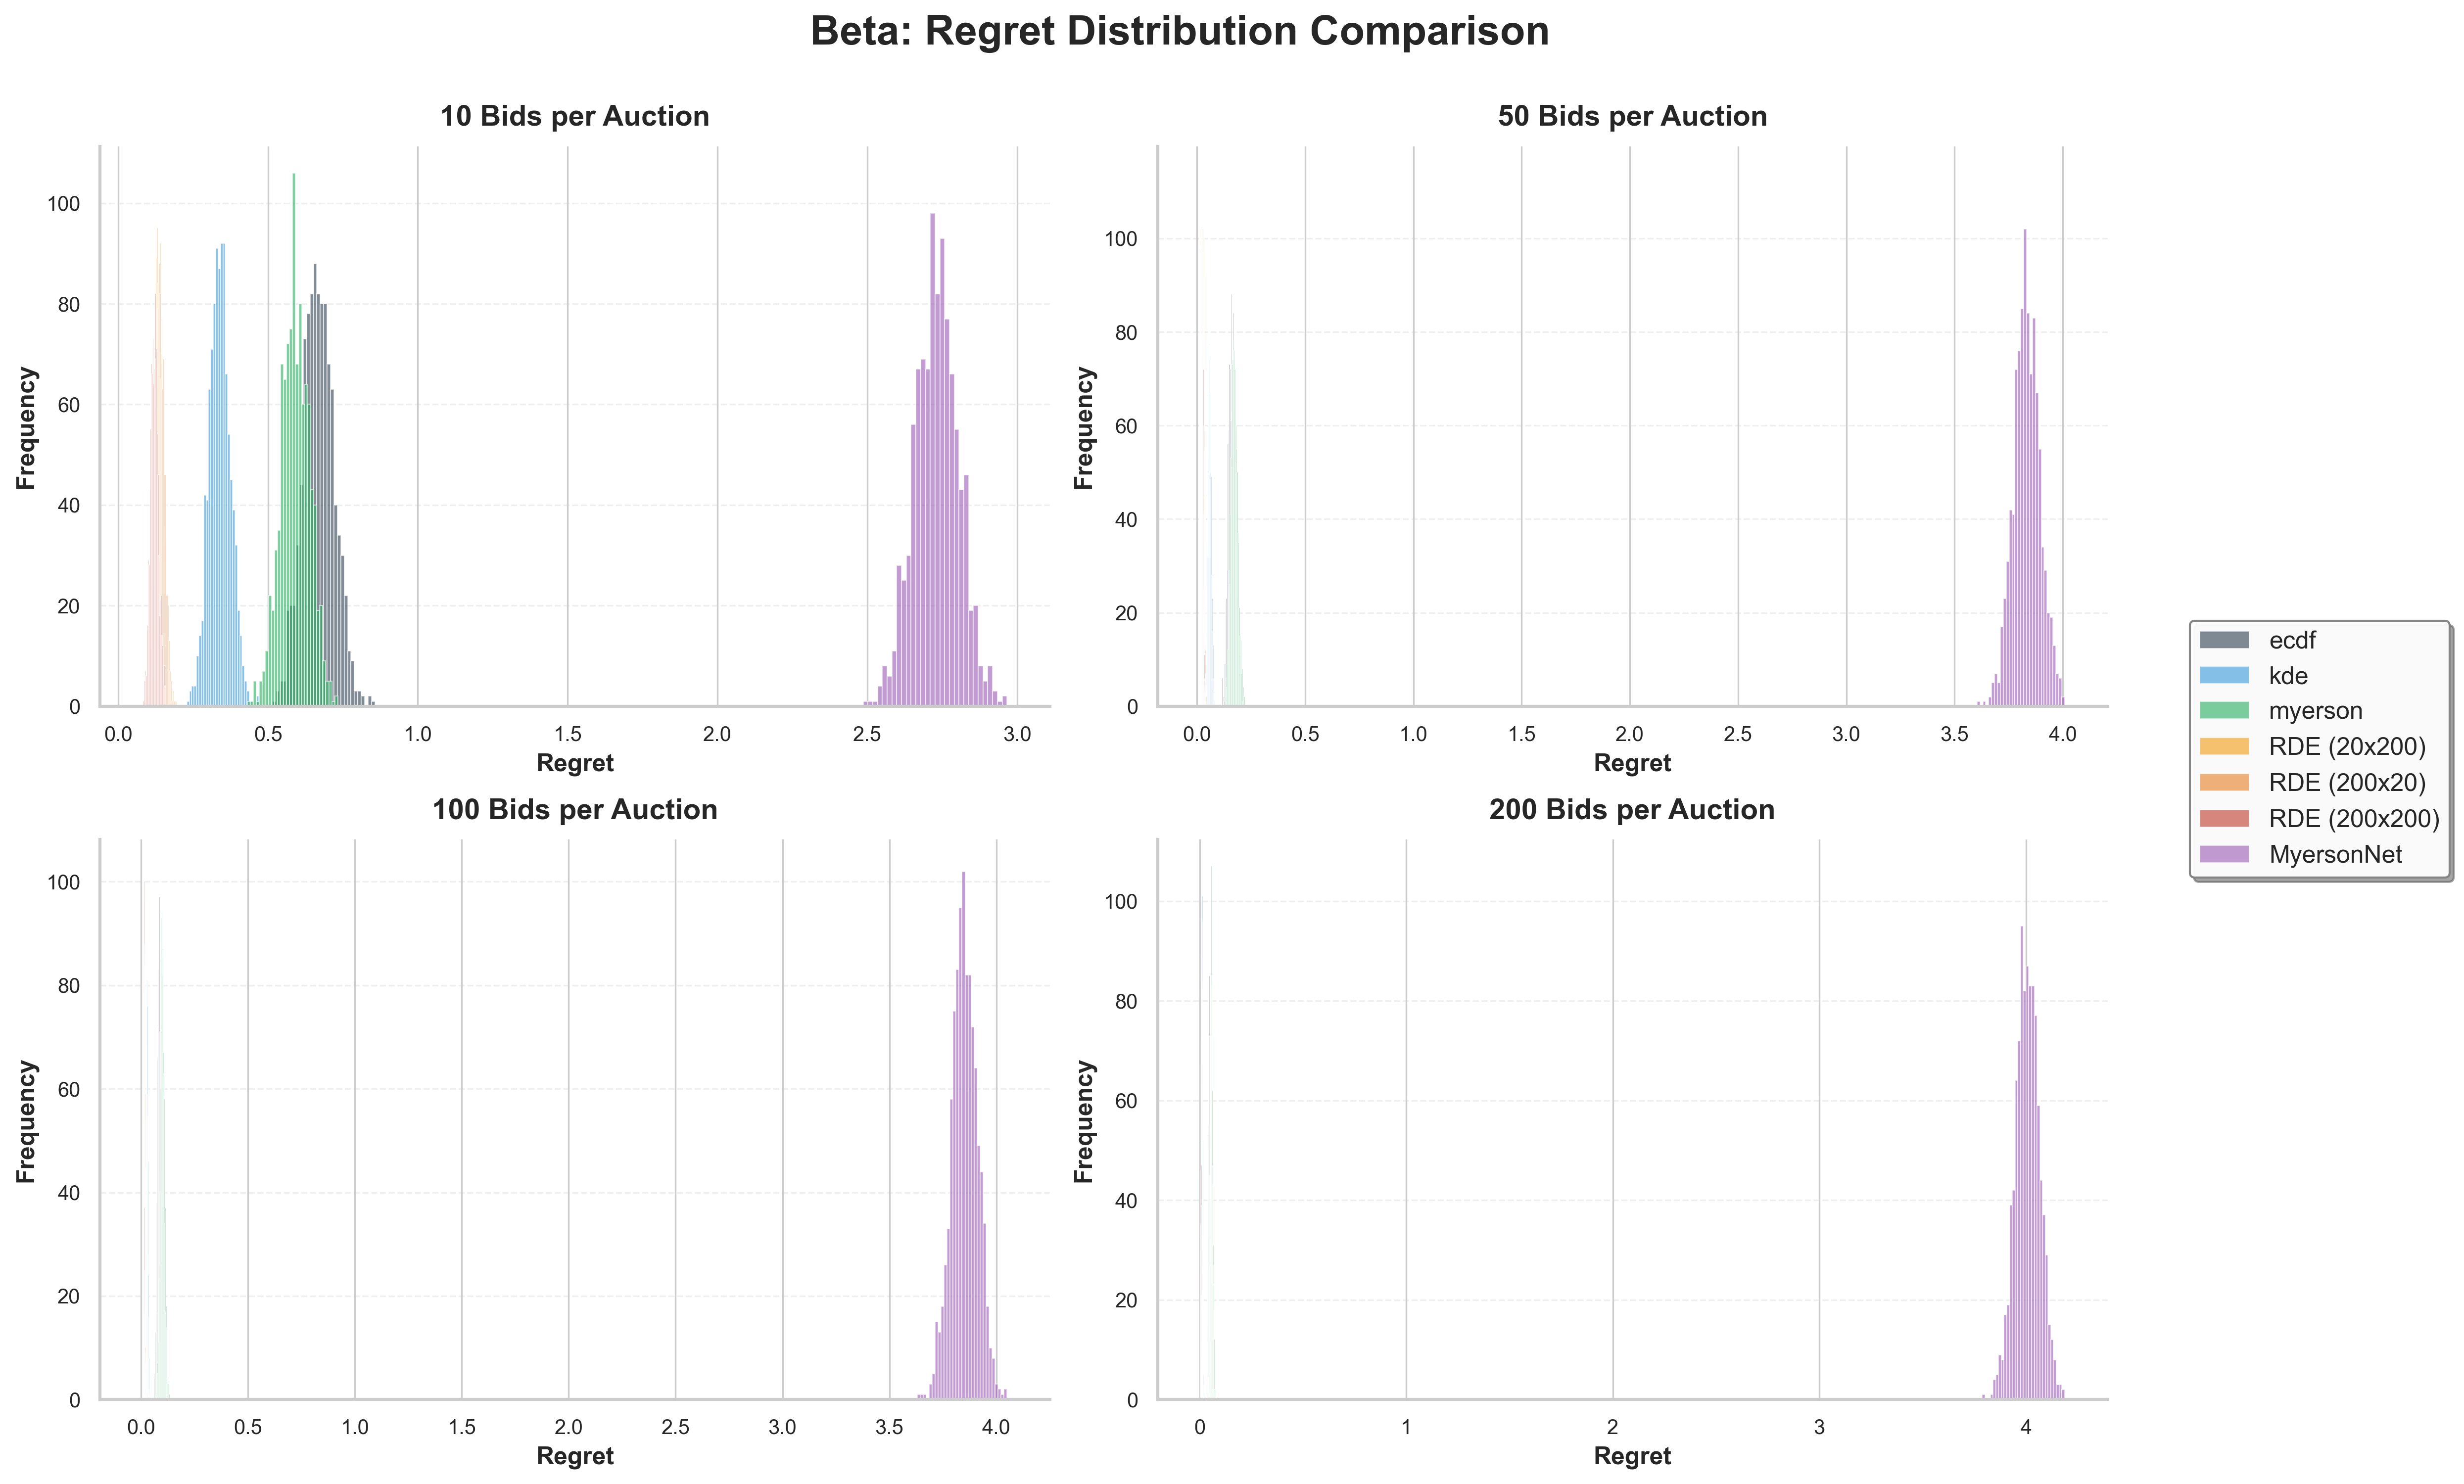

✅ Saved: histogram_truncpareto_k2.png (4 subplots: 10, 50, 100, 200 bids)


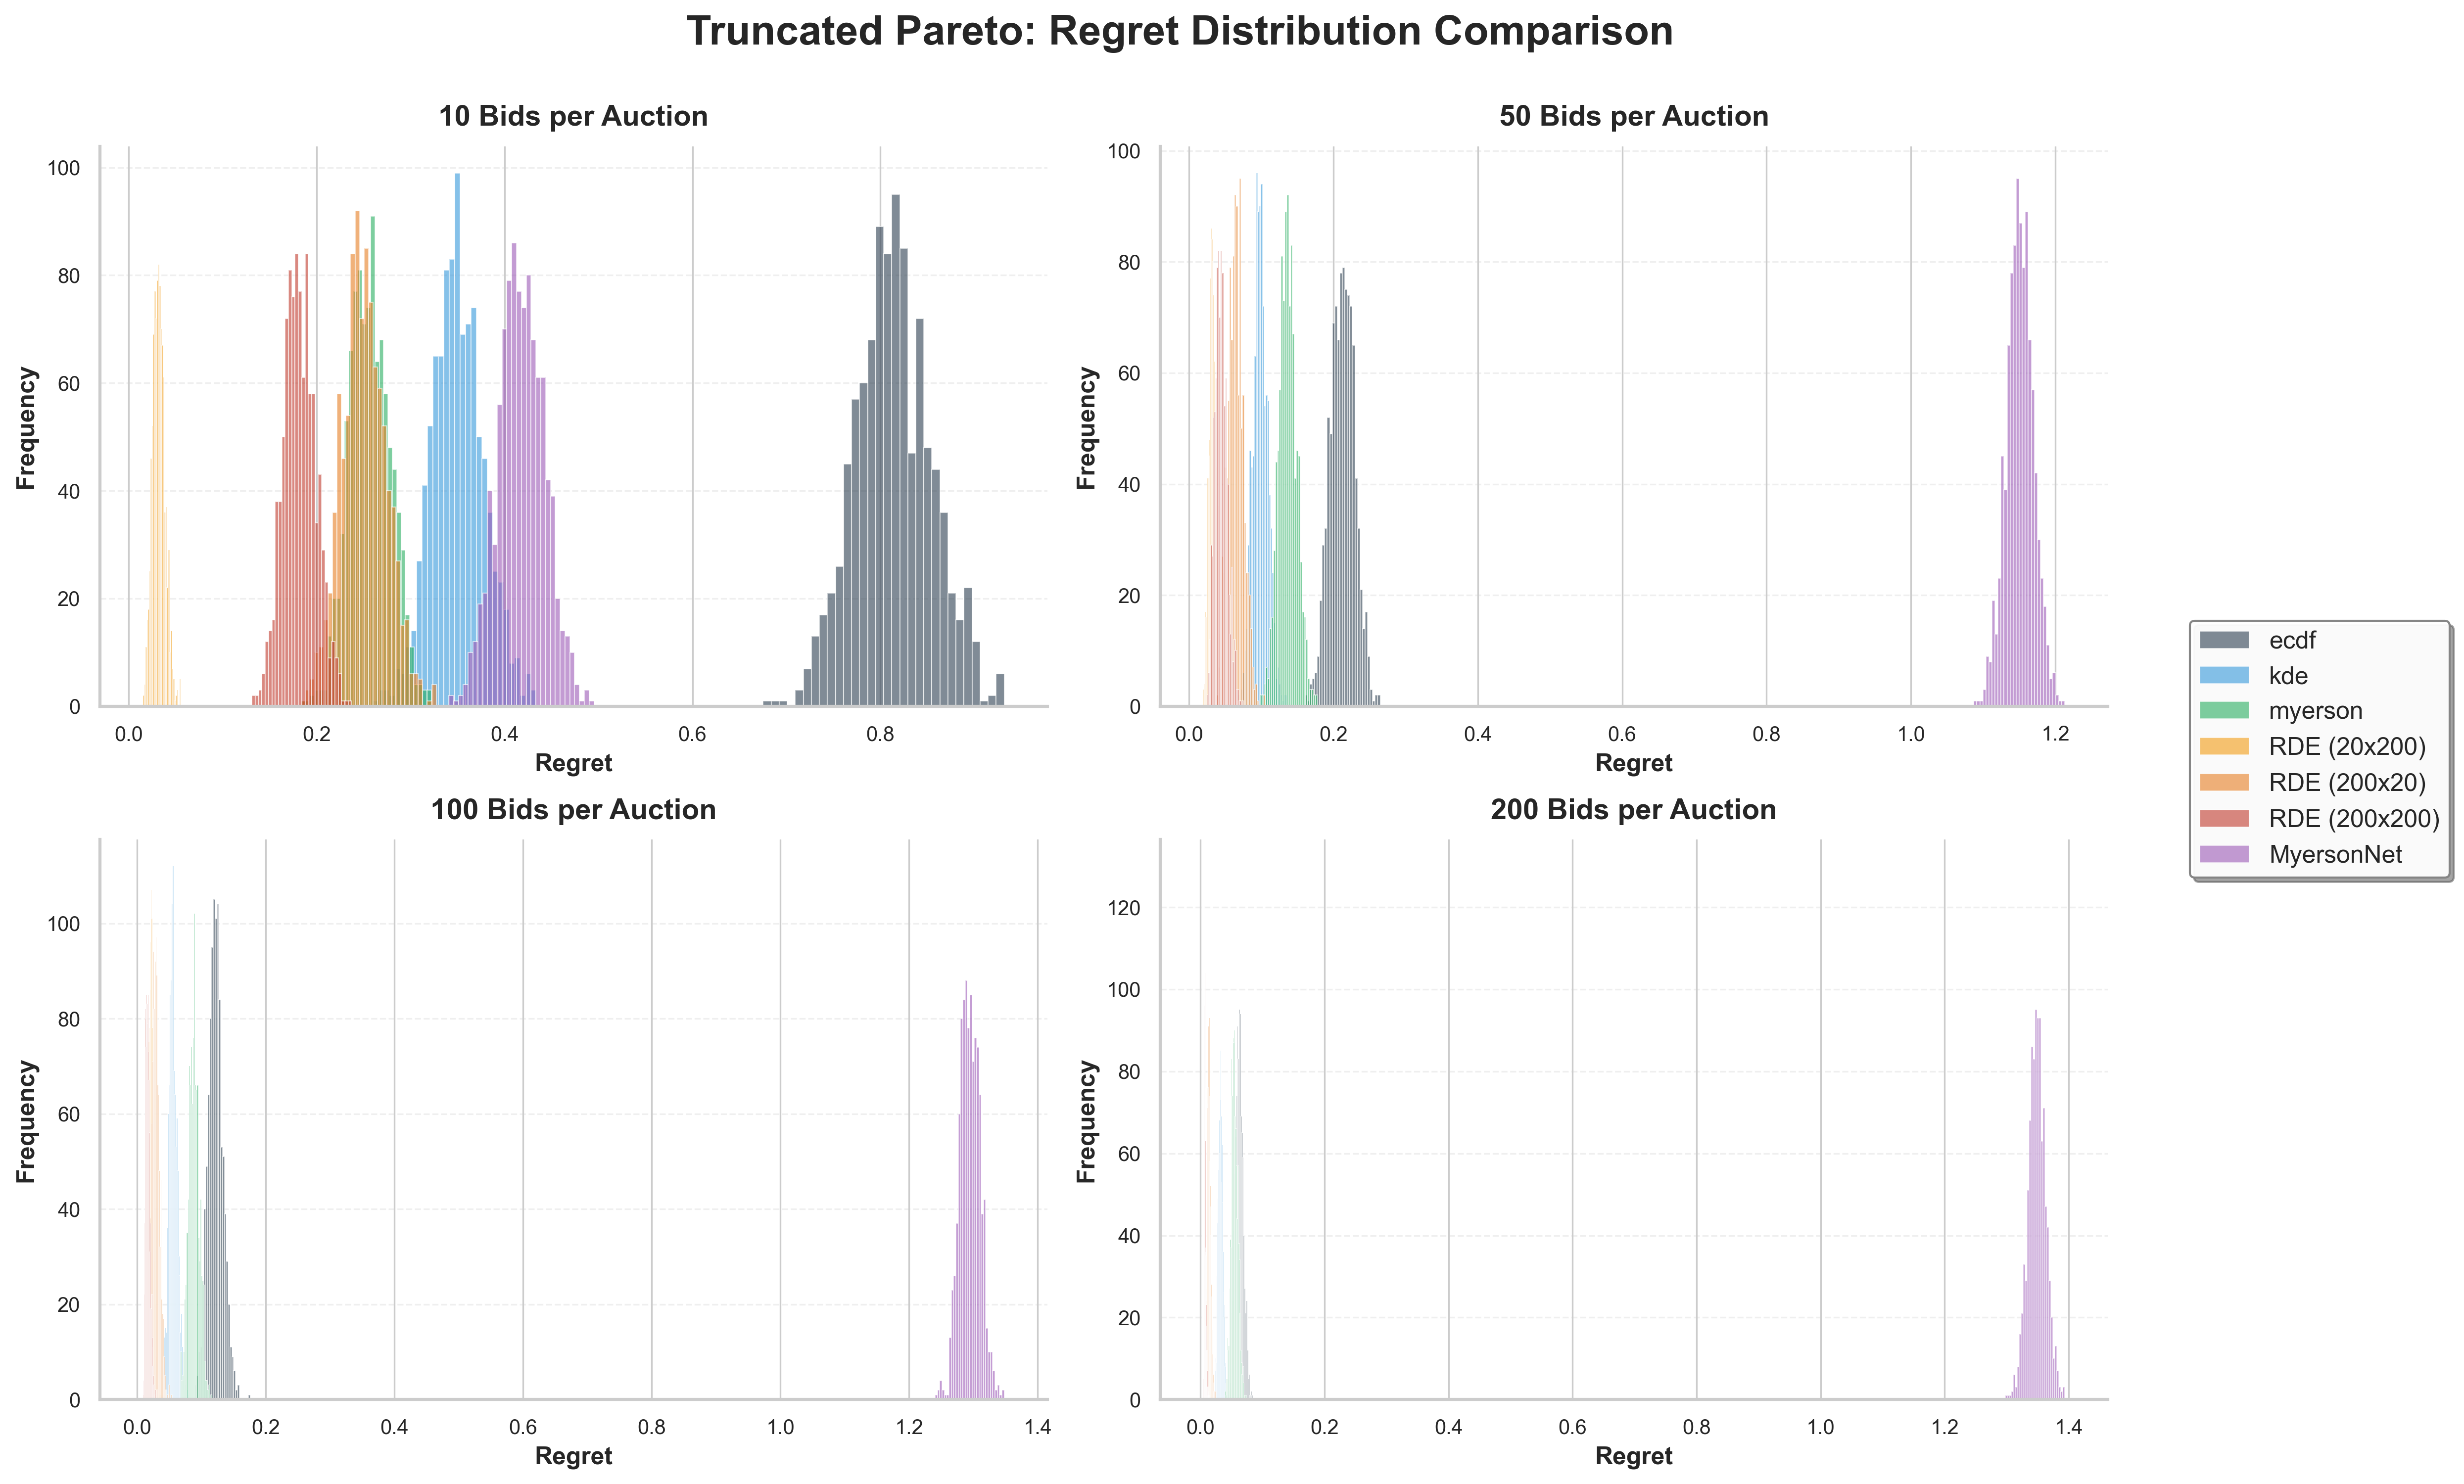

In [5]:
plot_regret_histograms(
    project_root=project_root,
    dist_names=DIST_NAMES,  # type: ignore
    bids_per_auction=BIDS_PER_AUCTION,  # [10, 50, 100, 200]
    k_fold=2,  # Use K=2 for histogram comparison
    save_dir="workspace/plots/histograms",
    show=True,
)

In [6]:
METHODS_WITHOUT_MYERSONNET = [
    "ecdf",
    "kde",
    "myerson",
    "RDE (20x200)",
    "RDE (200x20)",
    "RDE (200x200)",
]

✅ Saved: kfold_sensitivity_truncnorm_no_myersonnet.png (4 subplots: 10, 50, 100, 200 bids)


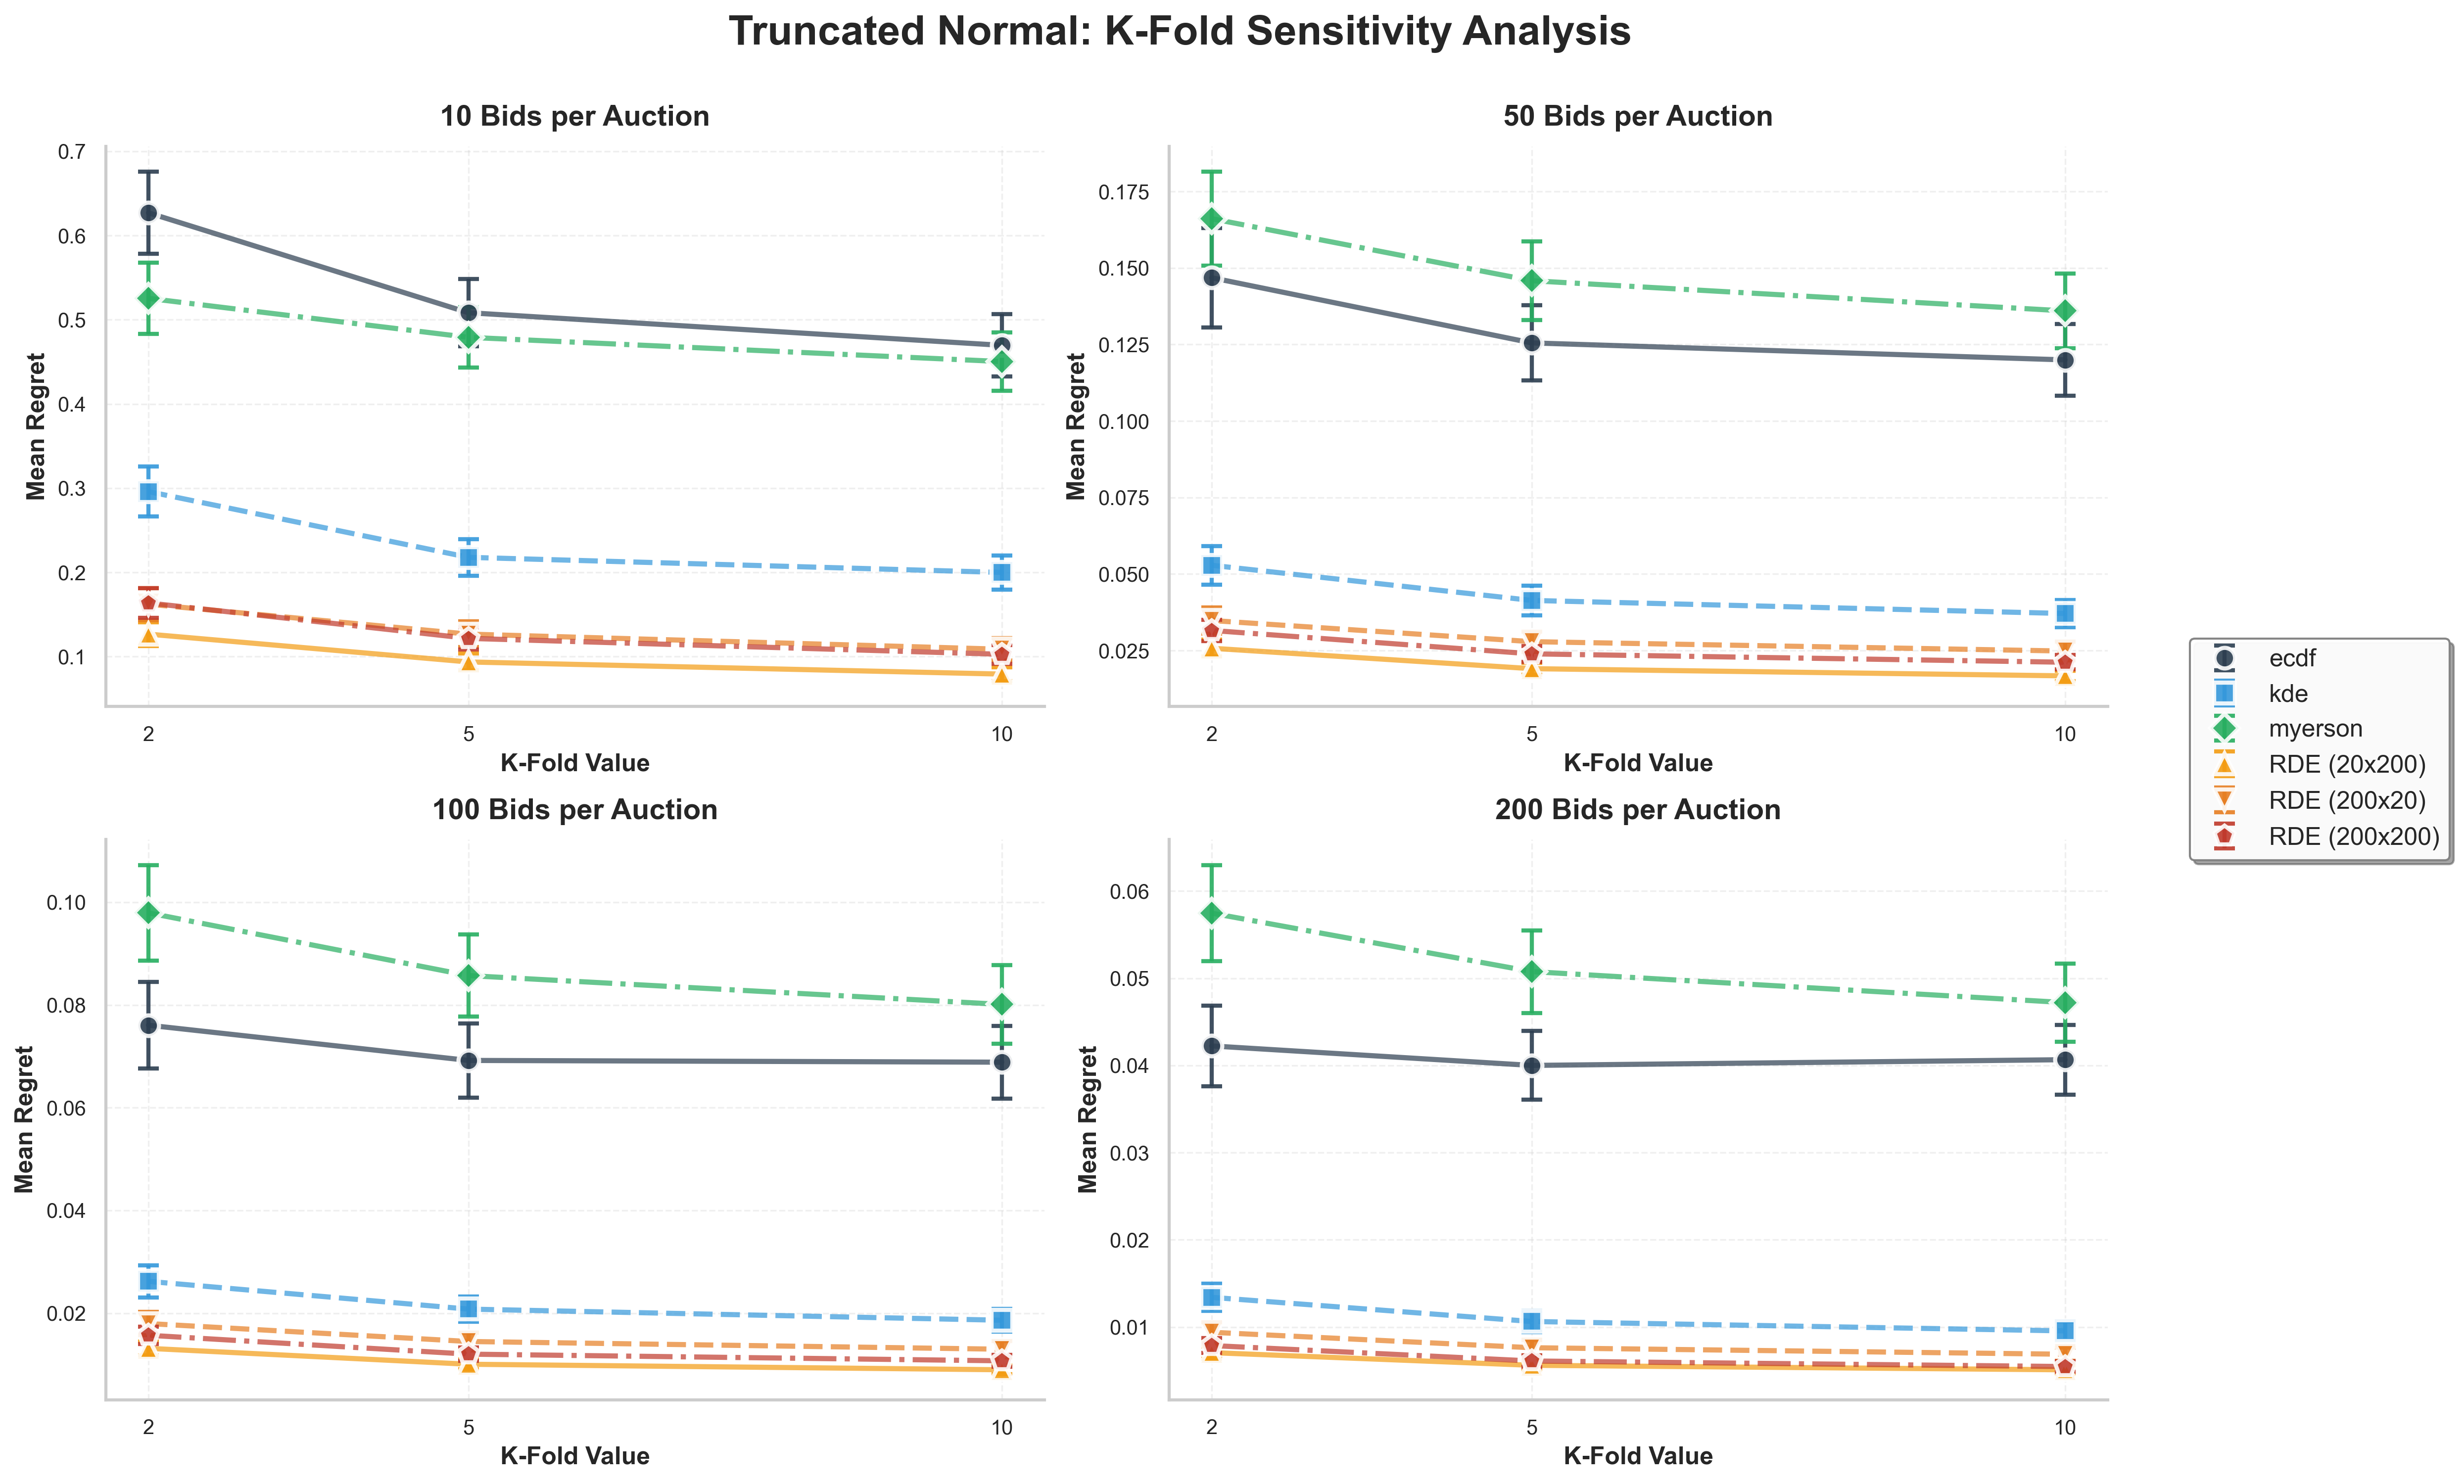

✅ Saved: kfold_sensitivity_truncexpon_no_myersonnet.png (4 subplots: 10, 50, 100, 200 bids)


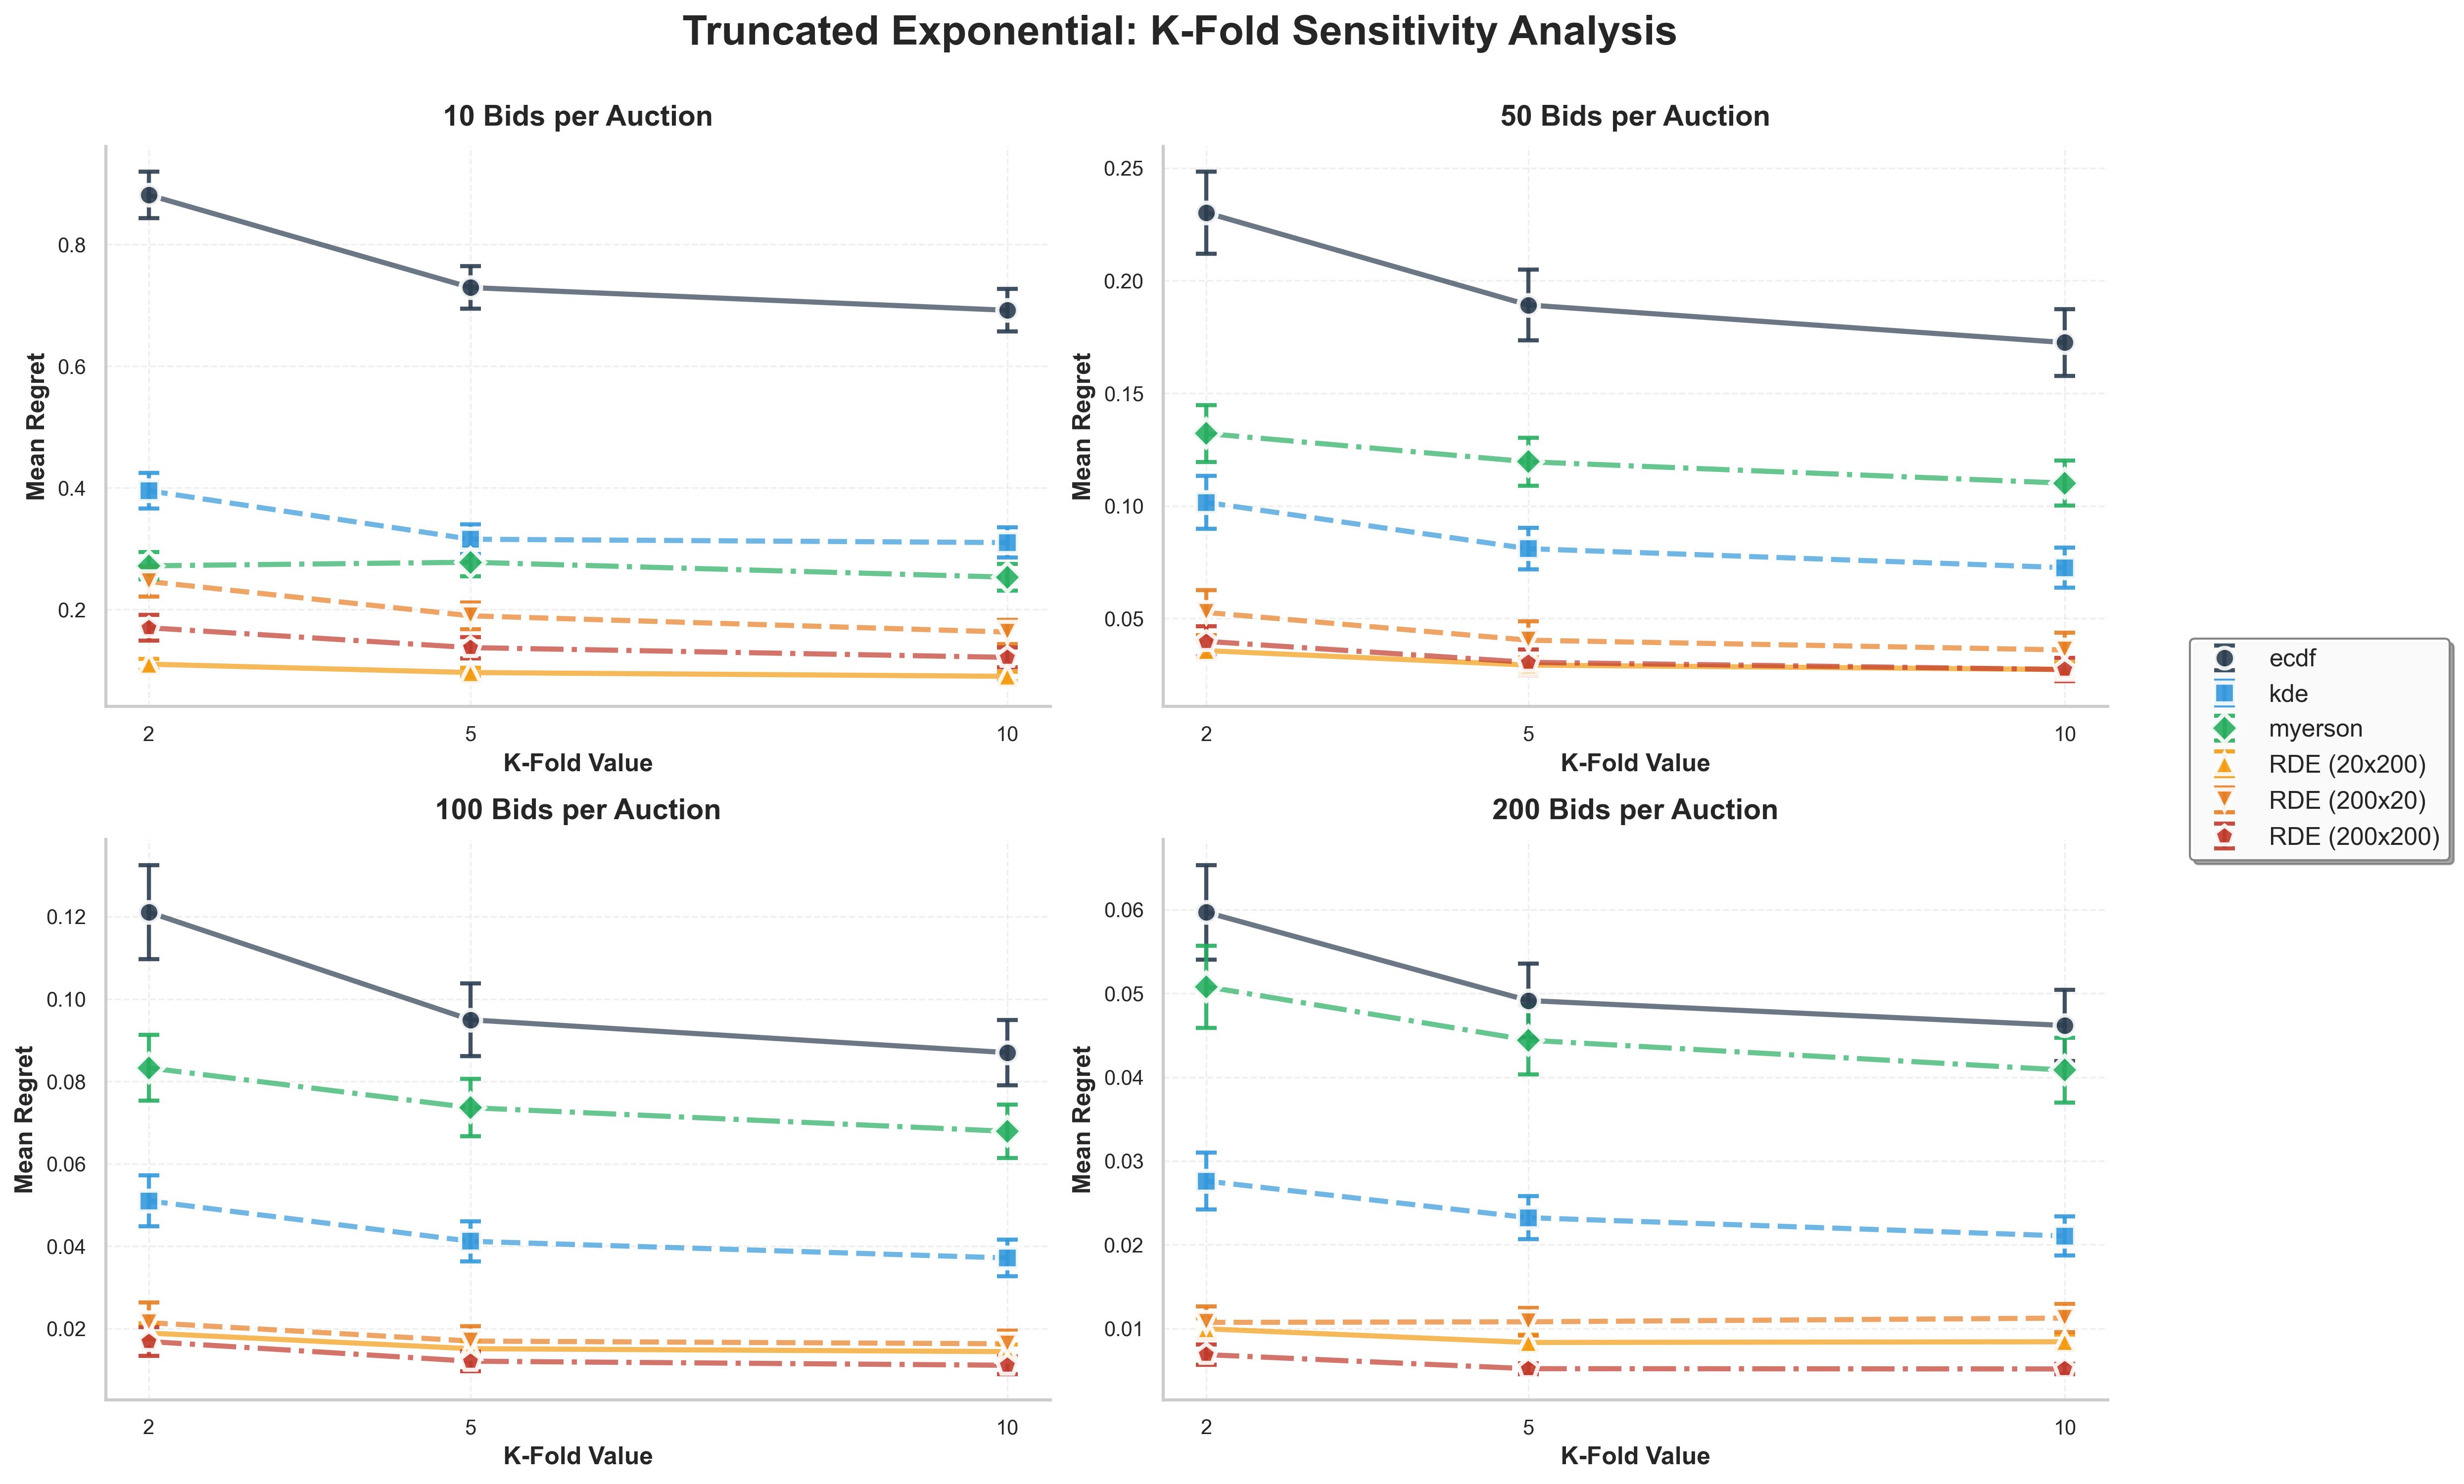

✅ Saved: kfold_sensitivity_beta_no_myersonnet.png (4 subplots: 10, 50, 100, 200 bids)


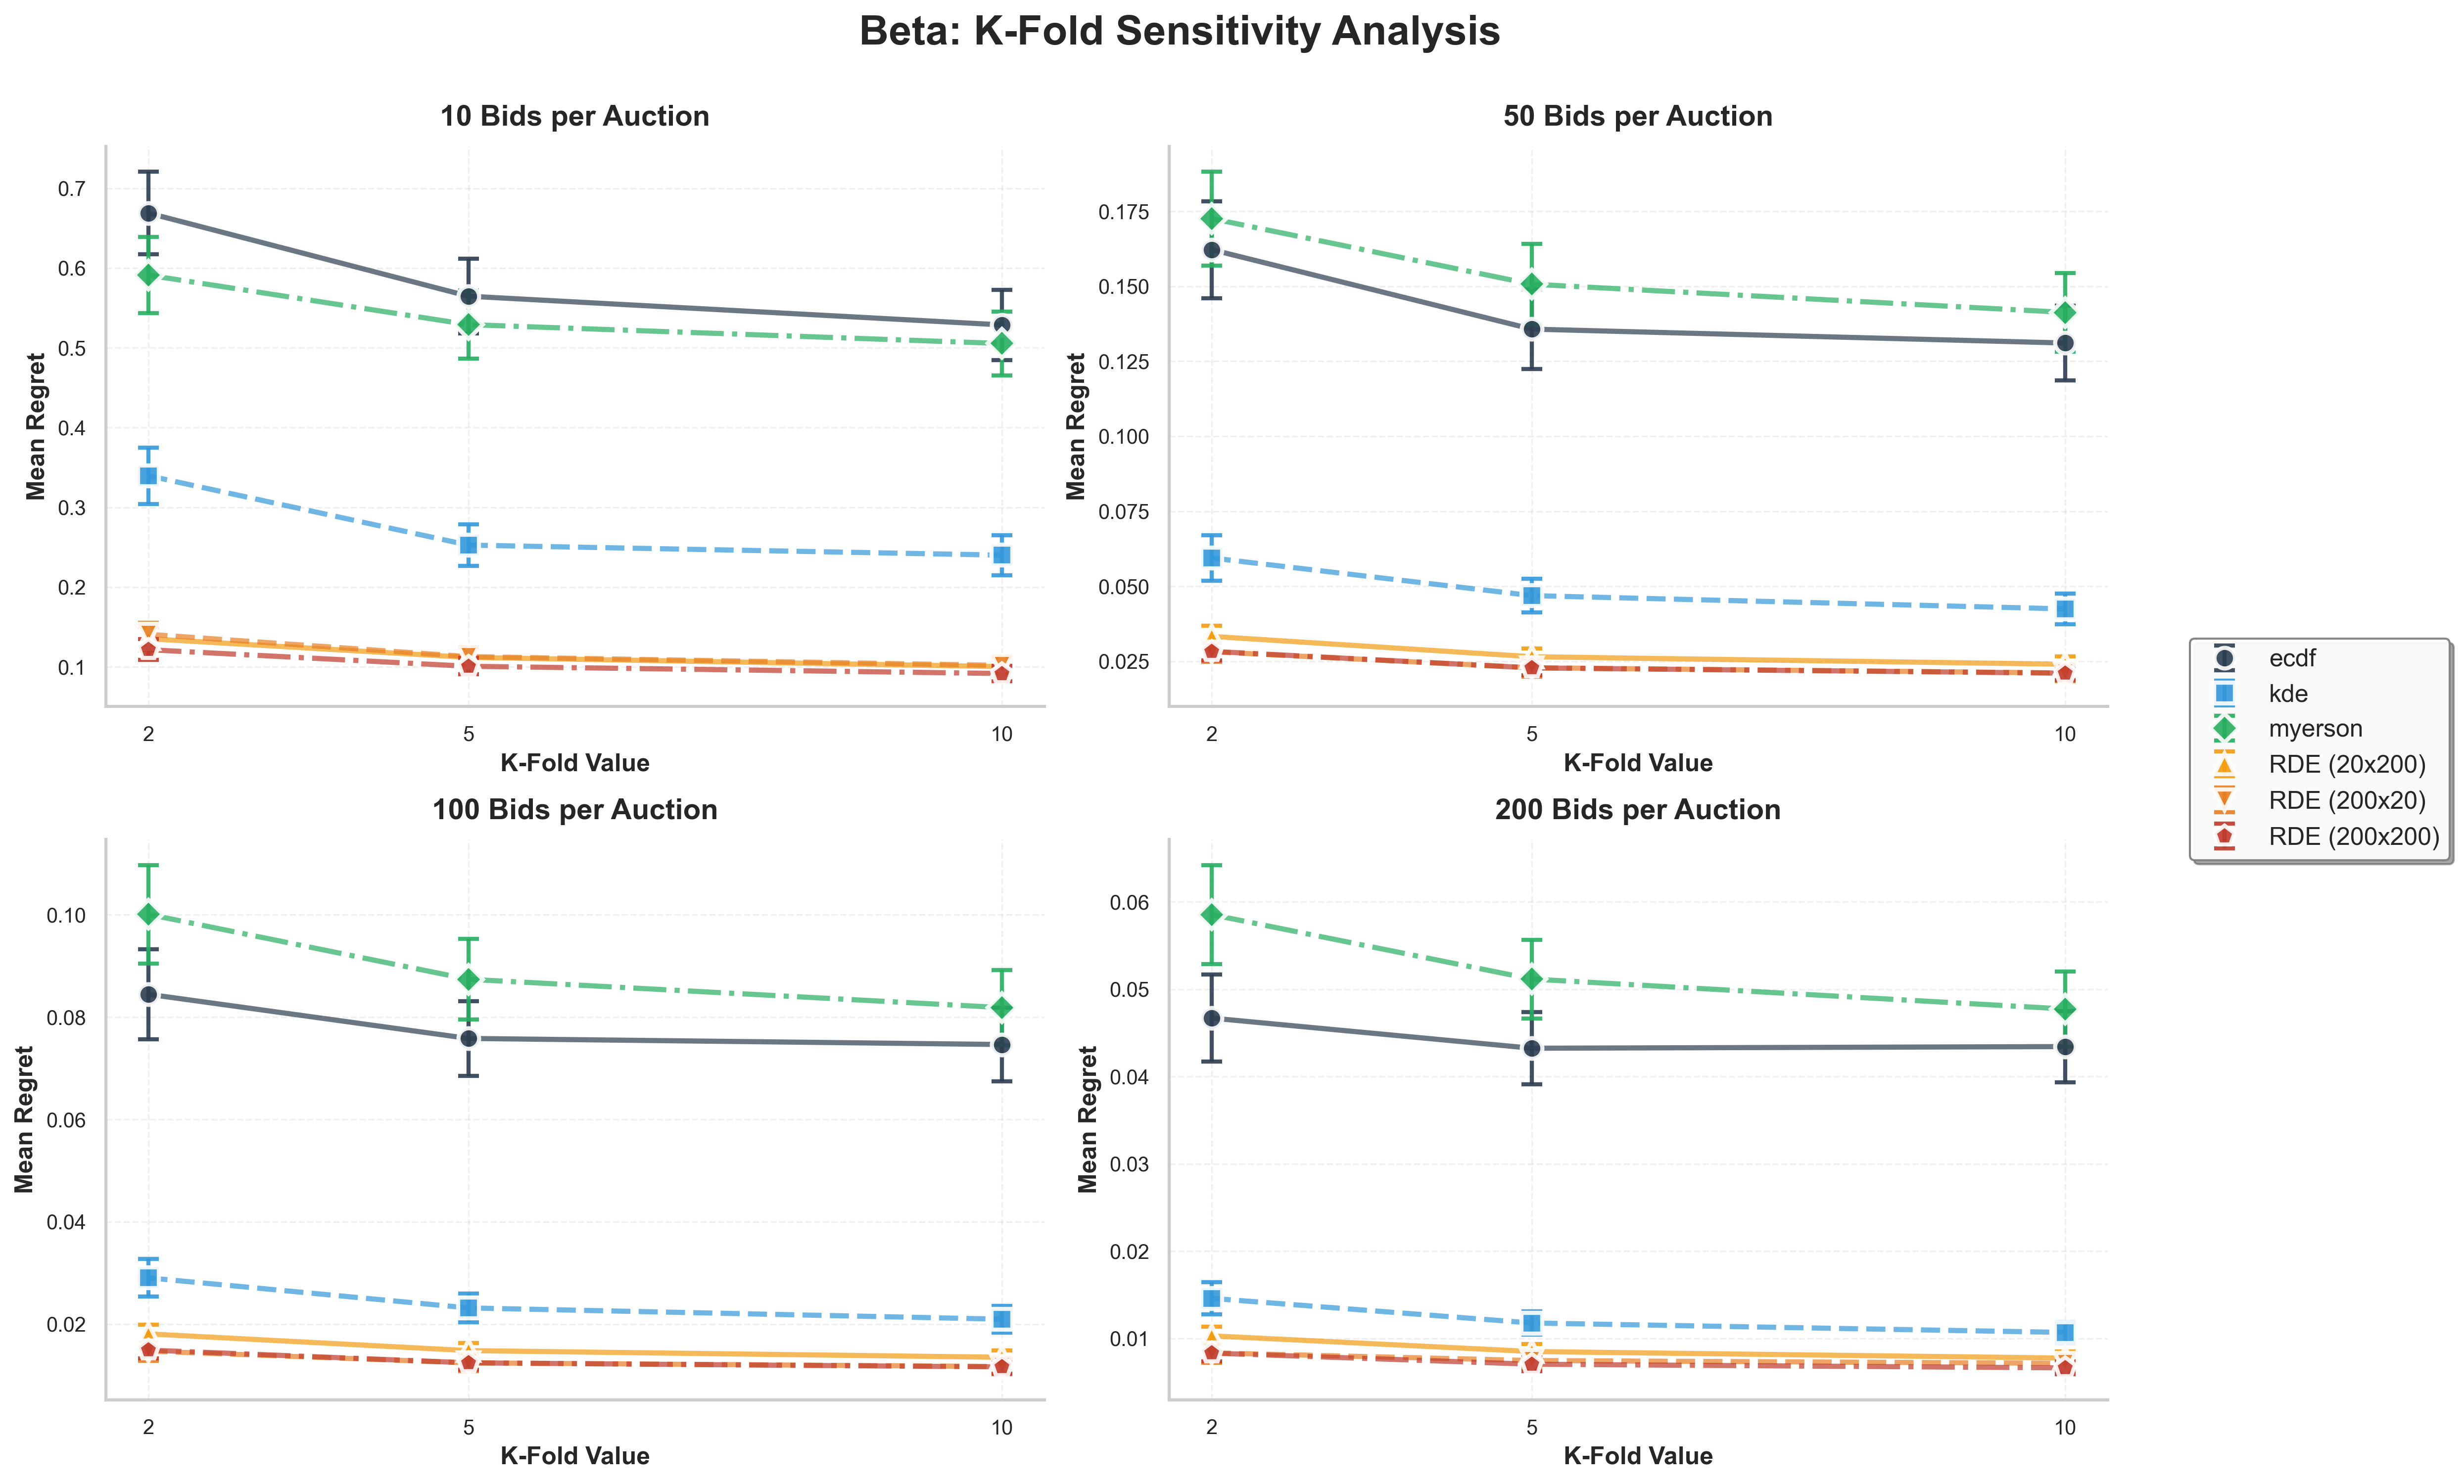

✅ Saved: kfold_sensitivity_truncpareto_no_myersonnet.png (4 subplots: 10, 50, 100, 200 bids)


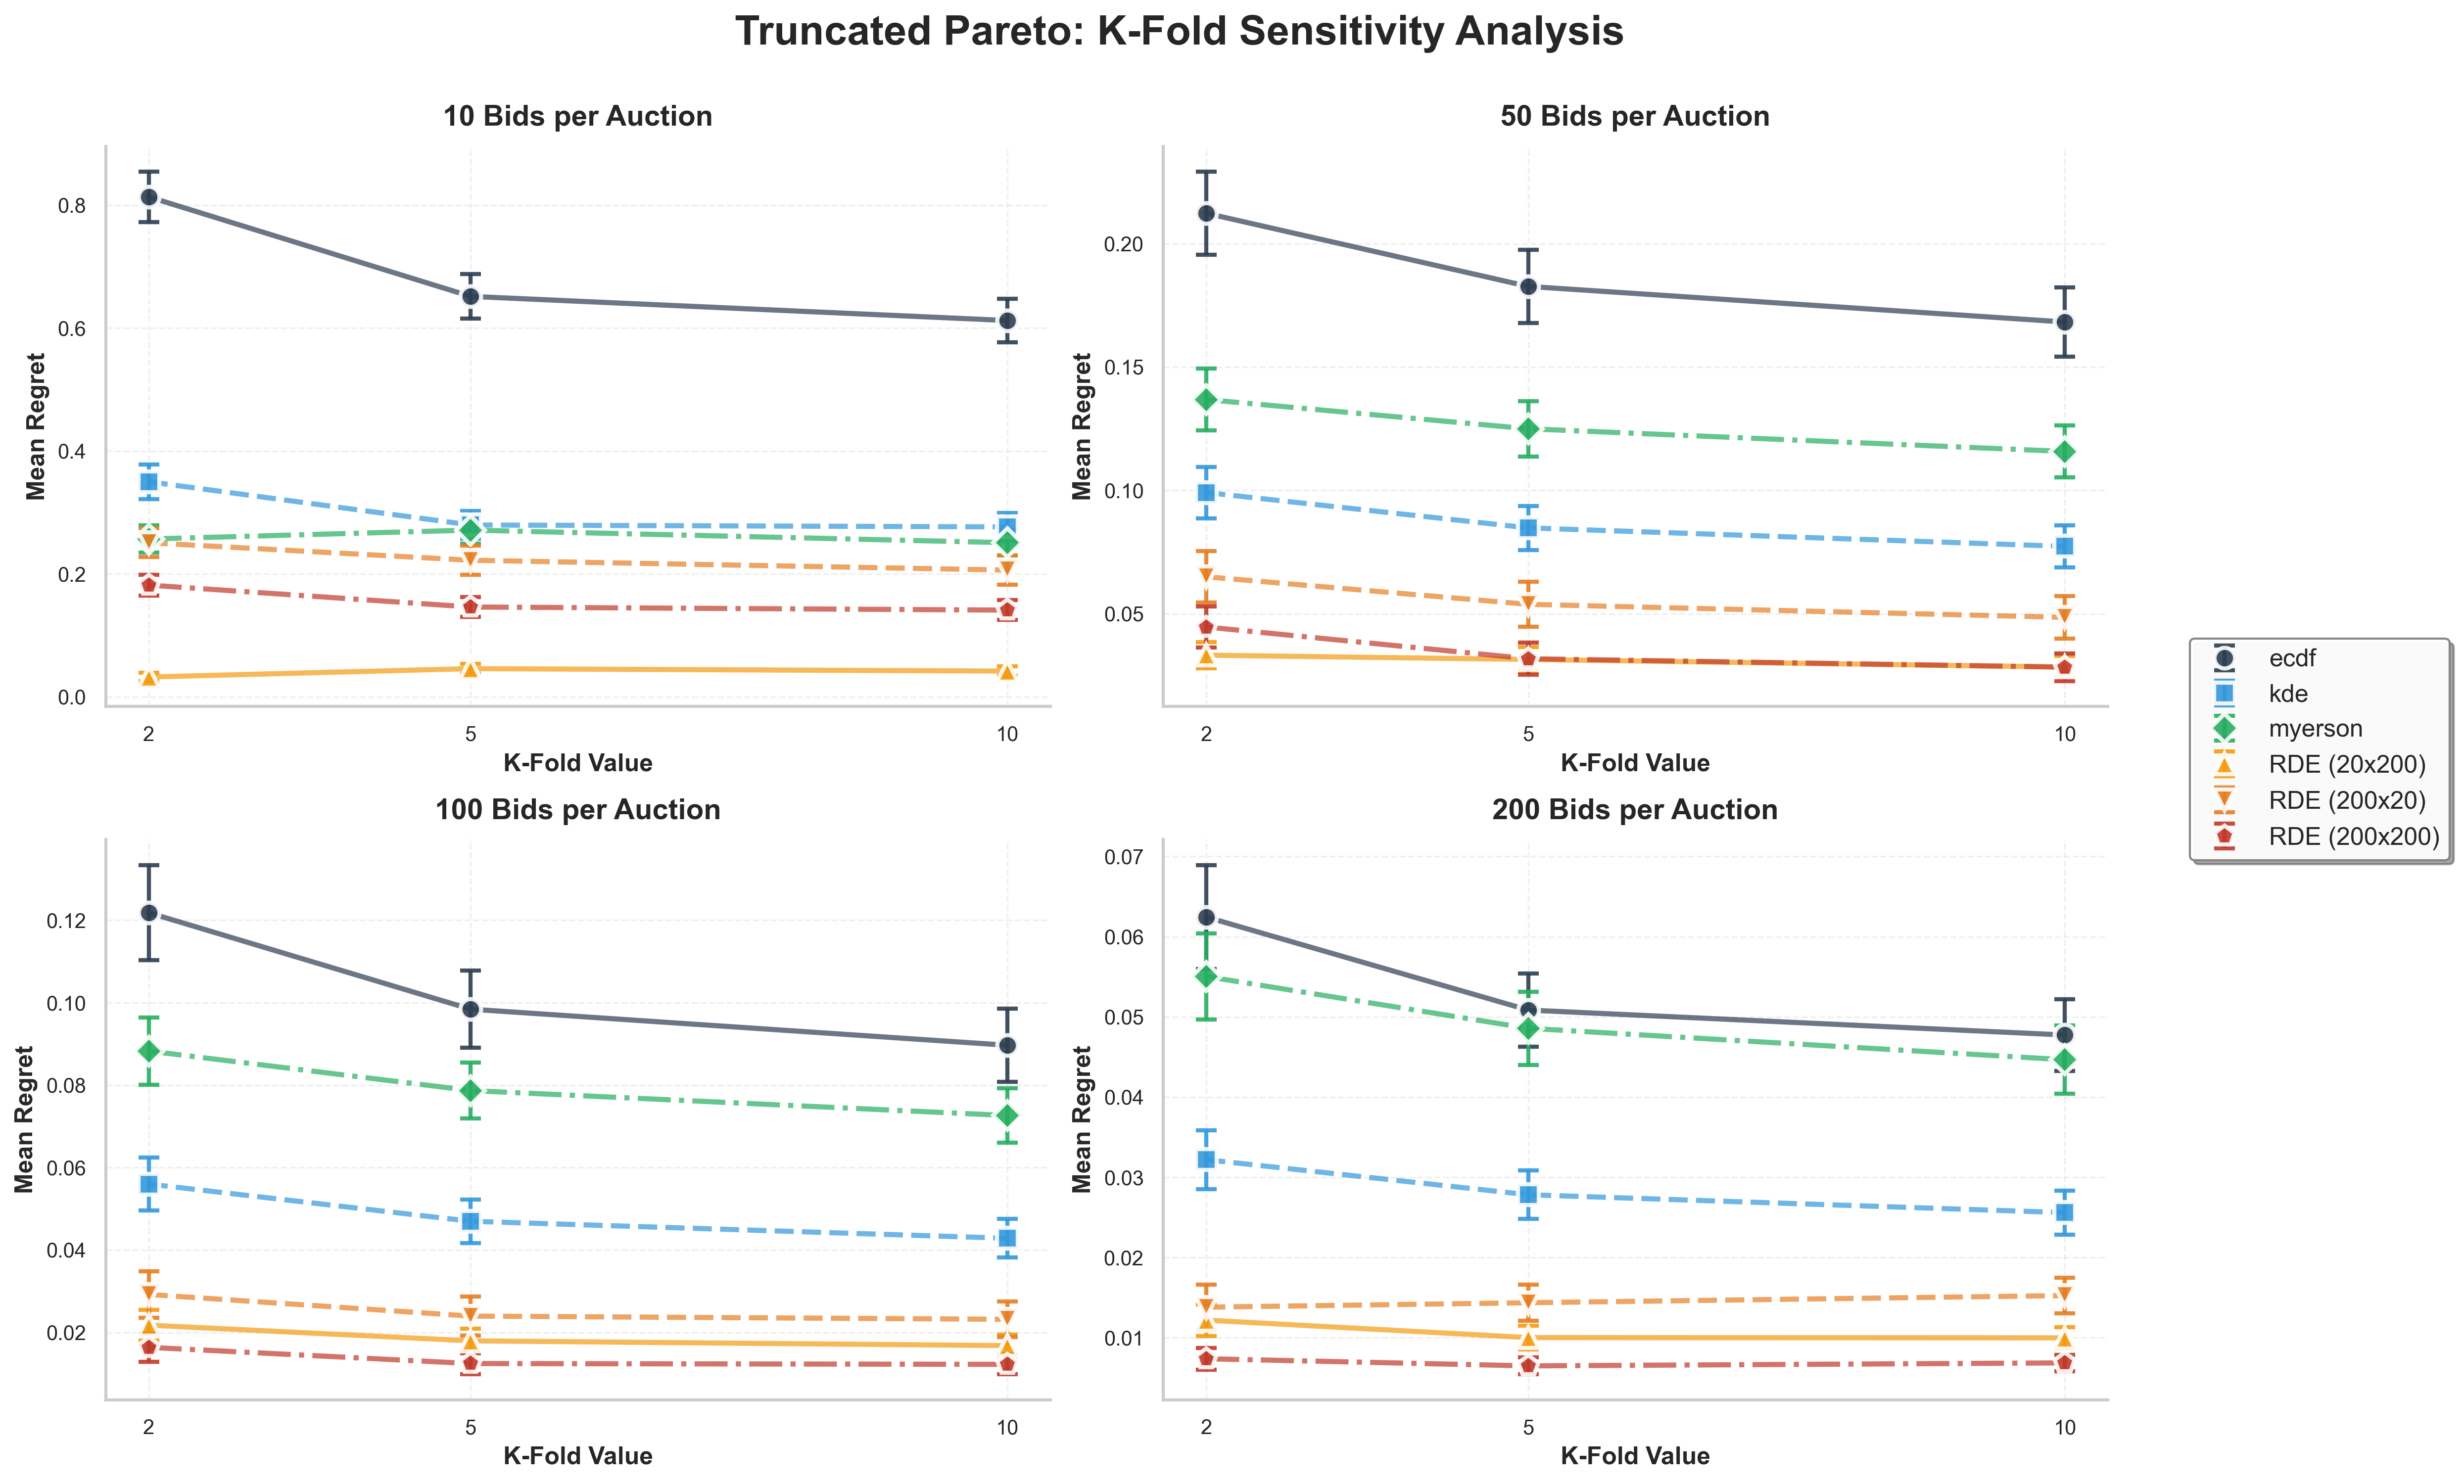

In [7]:
plot_kfold_sensitivity(
    project_root=project_root,
    dist_names=DIST_NAMES,  # type: ignore
    bids_per_auction=BIDS_PER_AUCTION,
    k_folds=K_FOLDS,
    methods=METHODS_WITHOUT_MYERSONNET,
    save_dir="workspace/plots/sensitivity",
    show=True,
    suffix="no_myersonnet",
)

✅ Saved: histogram_truncnorm_k2_no_myersonnet.png (4 subplots: 10, 50, 100, 200 bids)


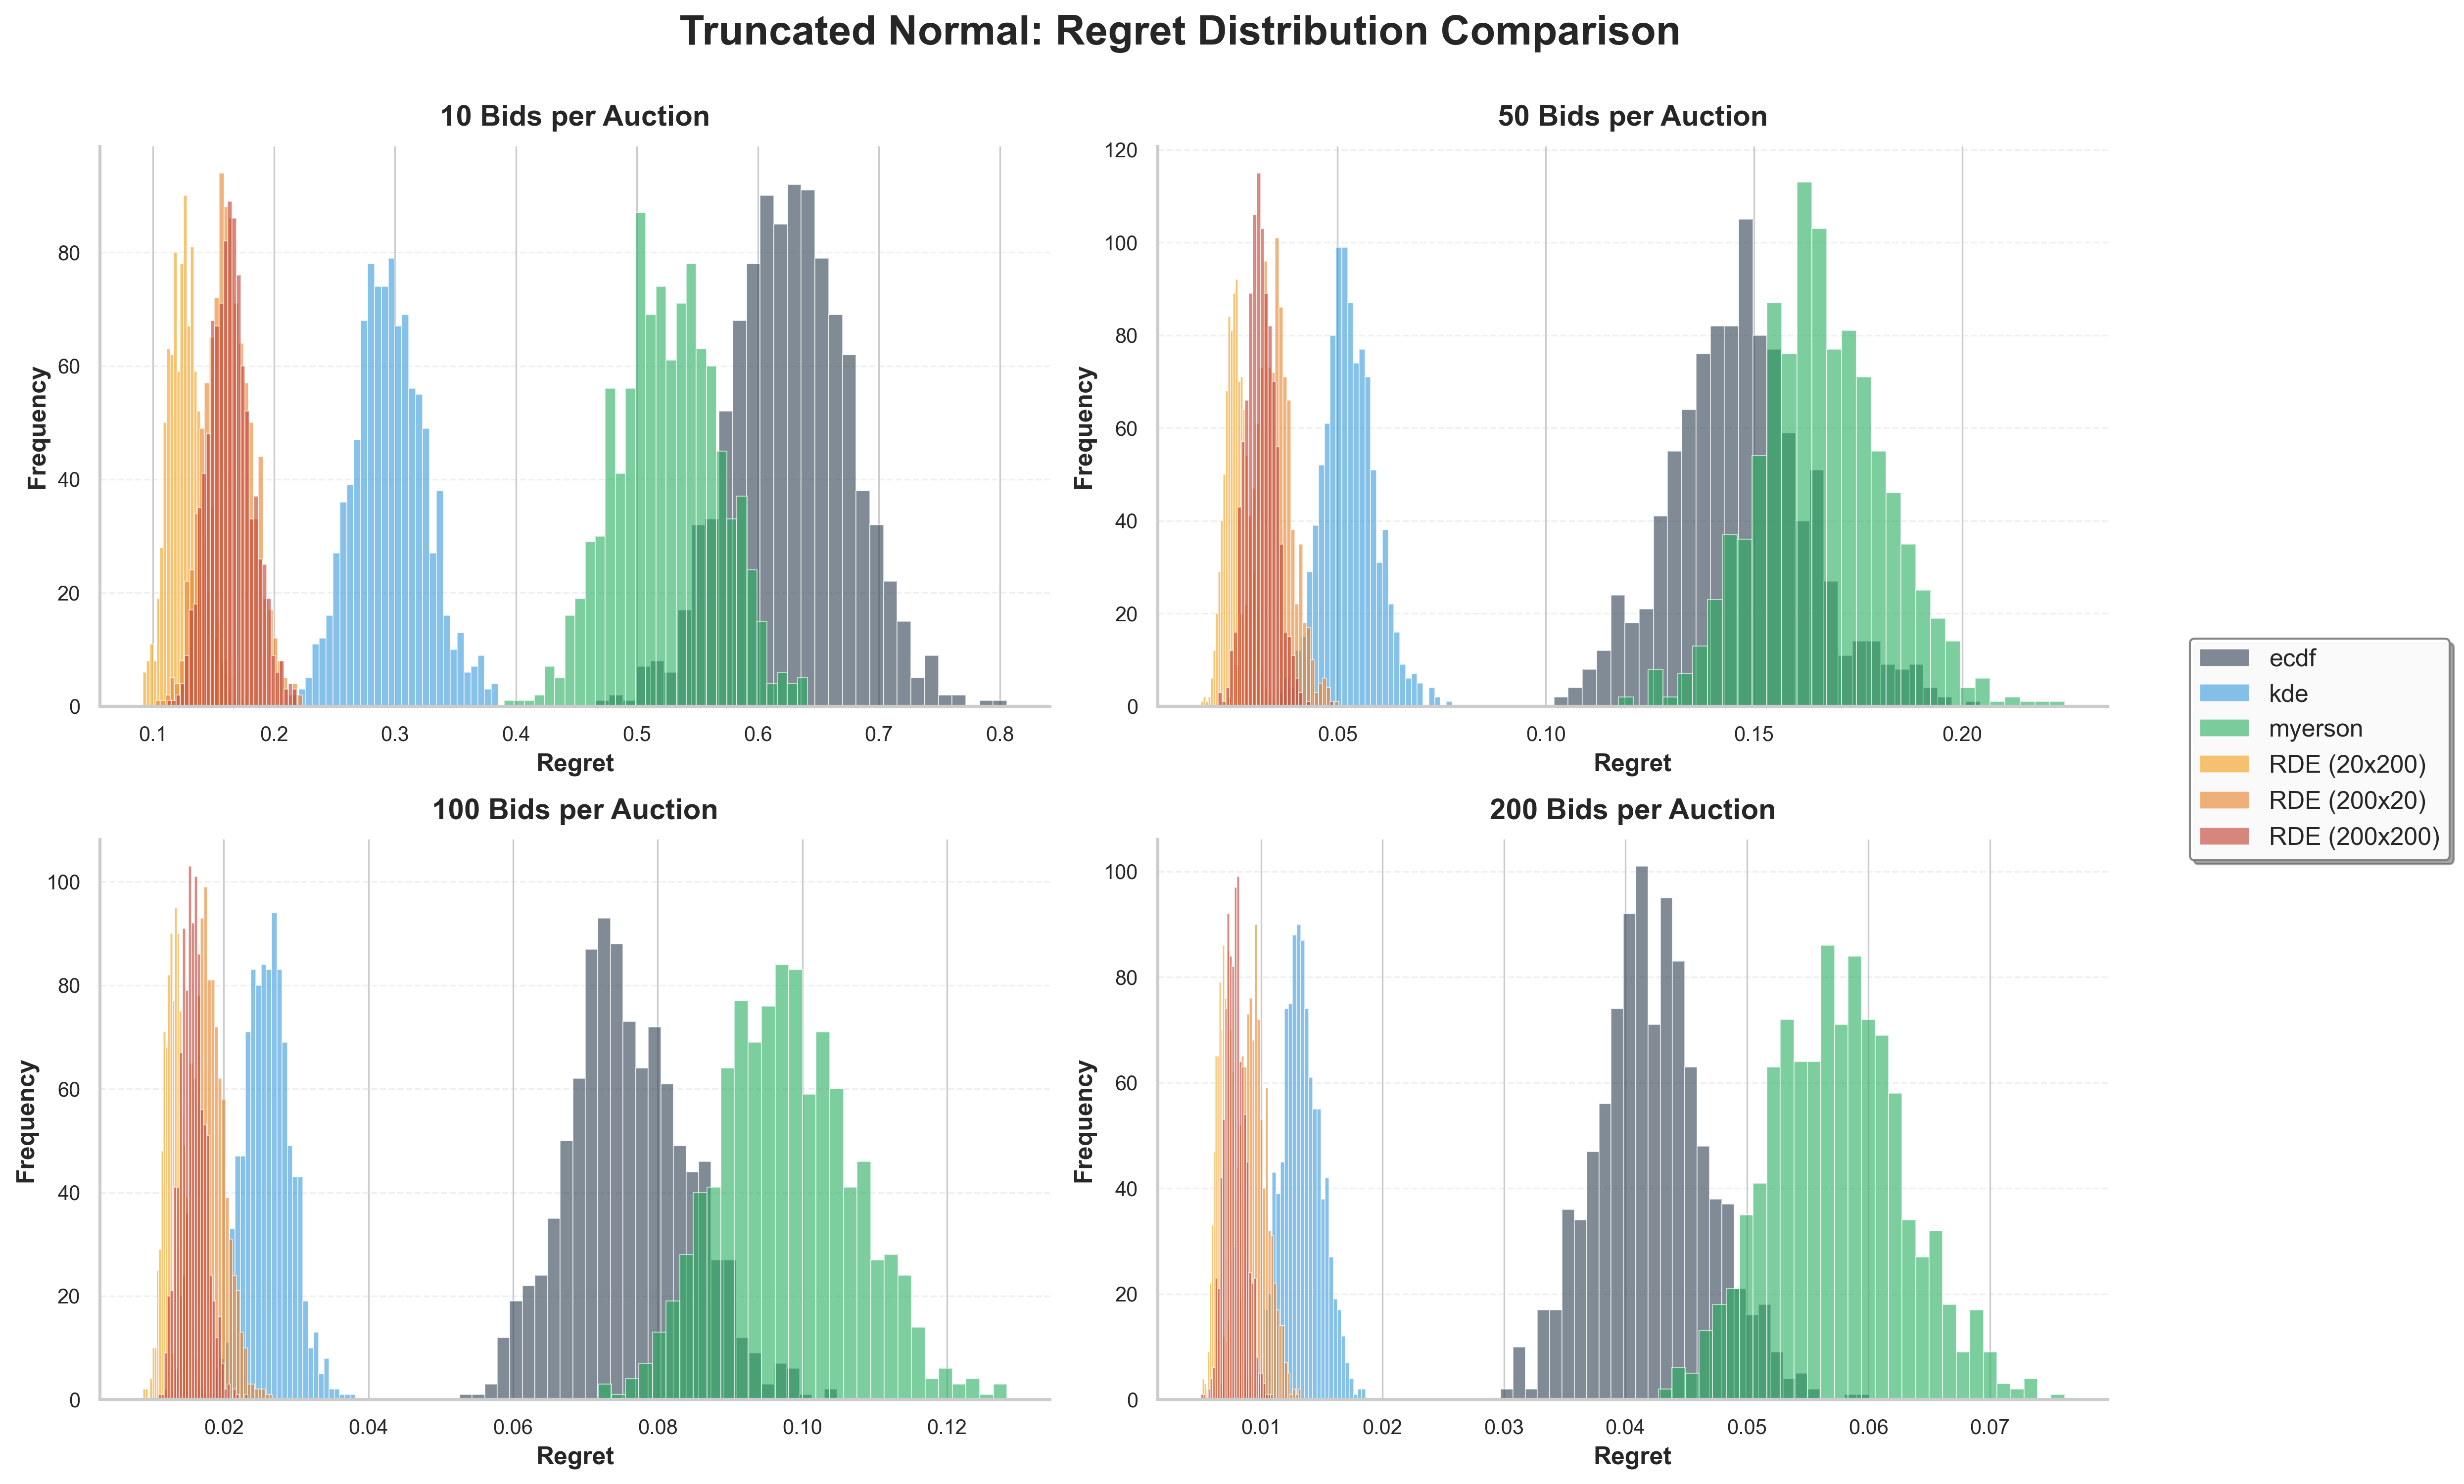

✅ Saved: histogram_truncexpon_k2_no_myersonnet.png (4 subplots: 10, 50, 100, 200 bids)


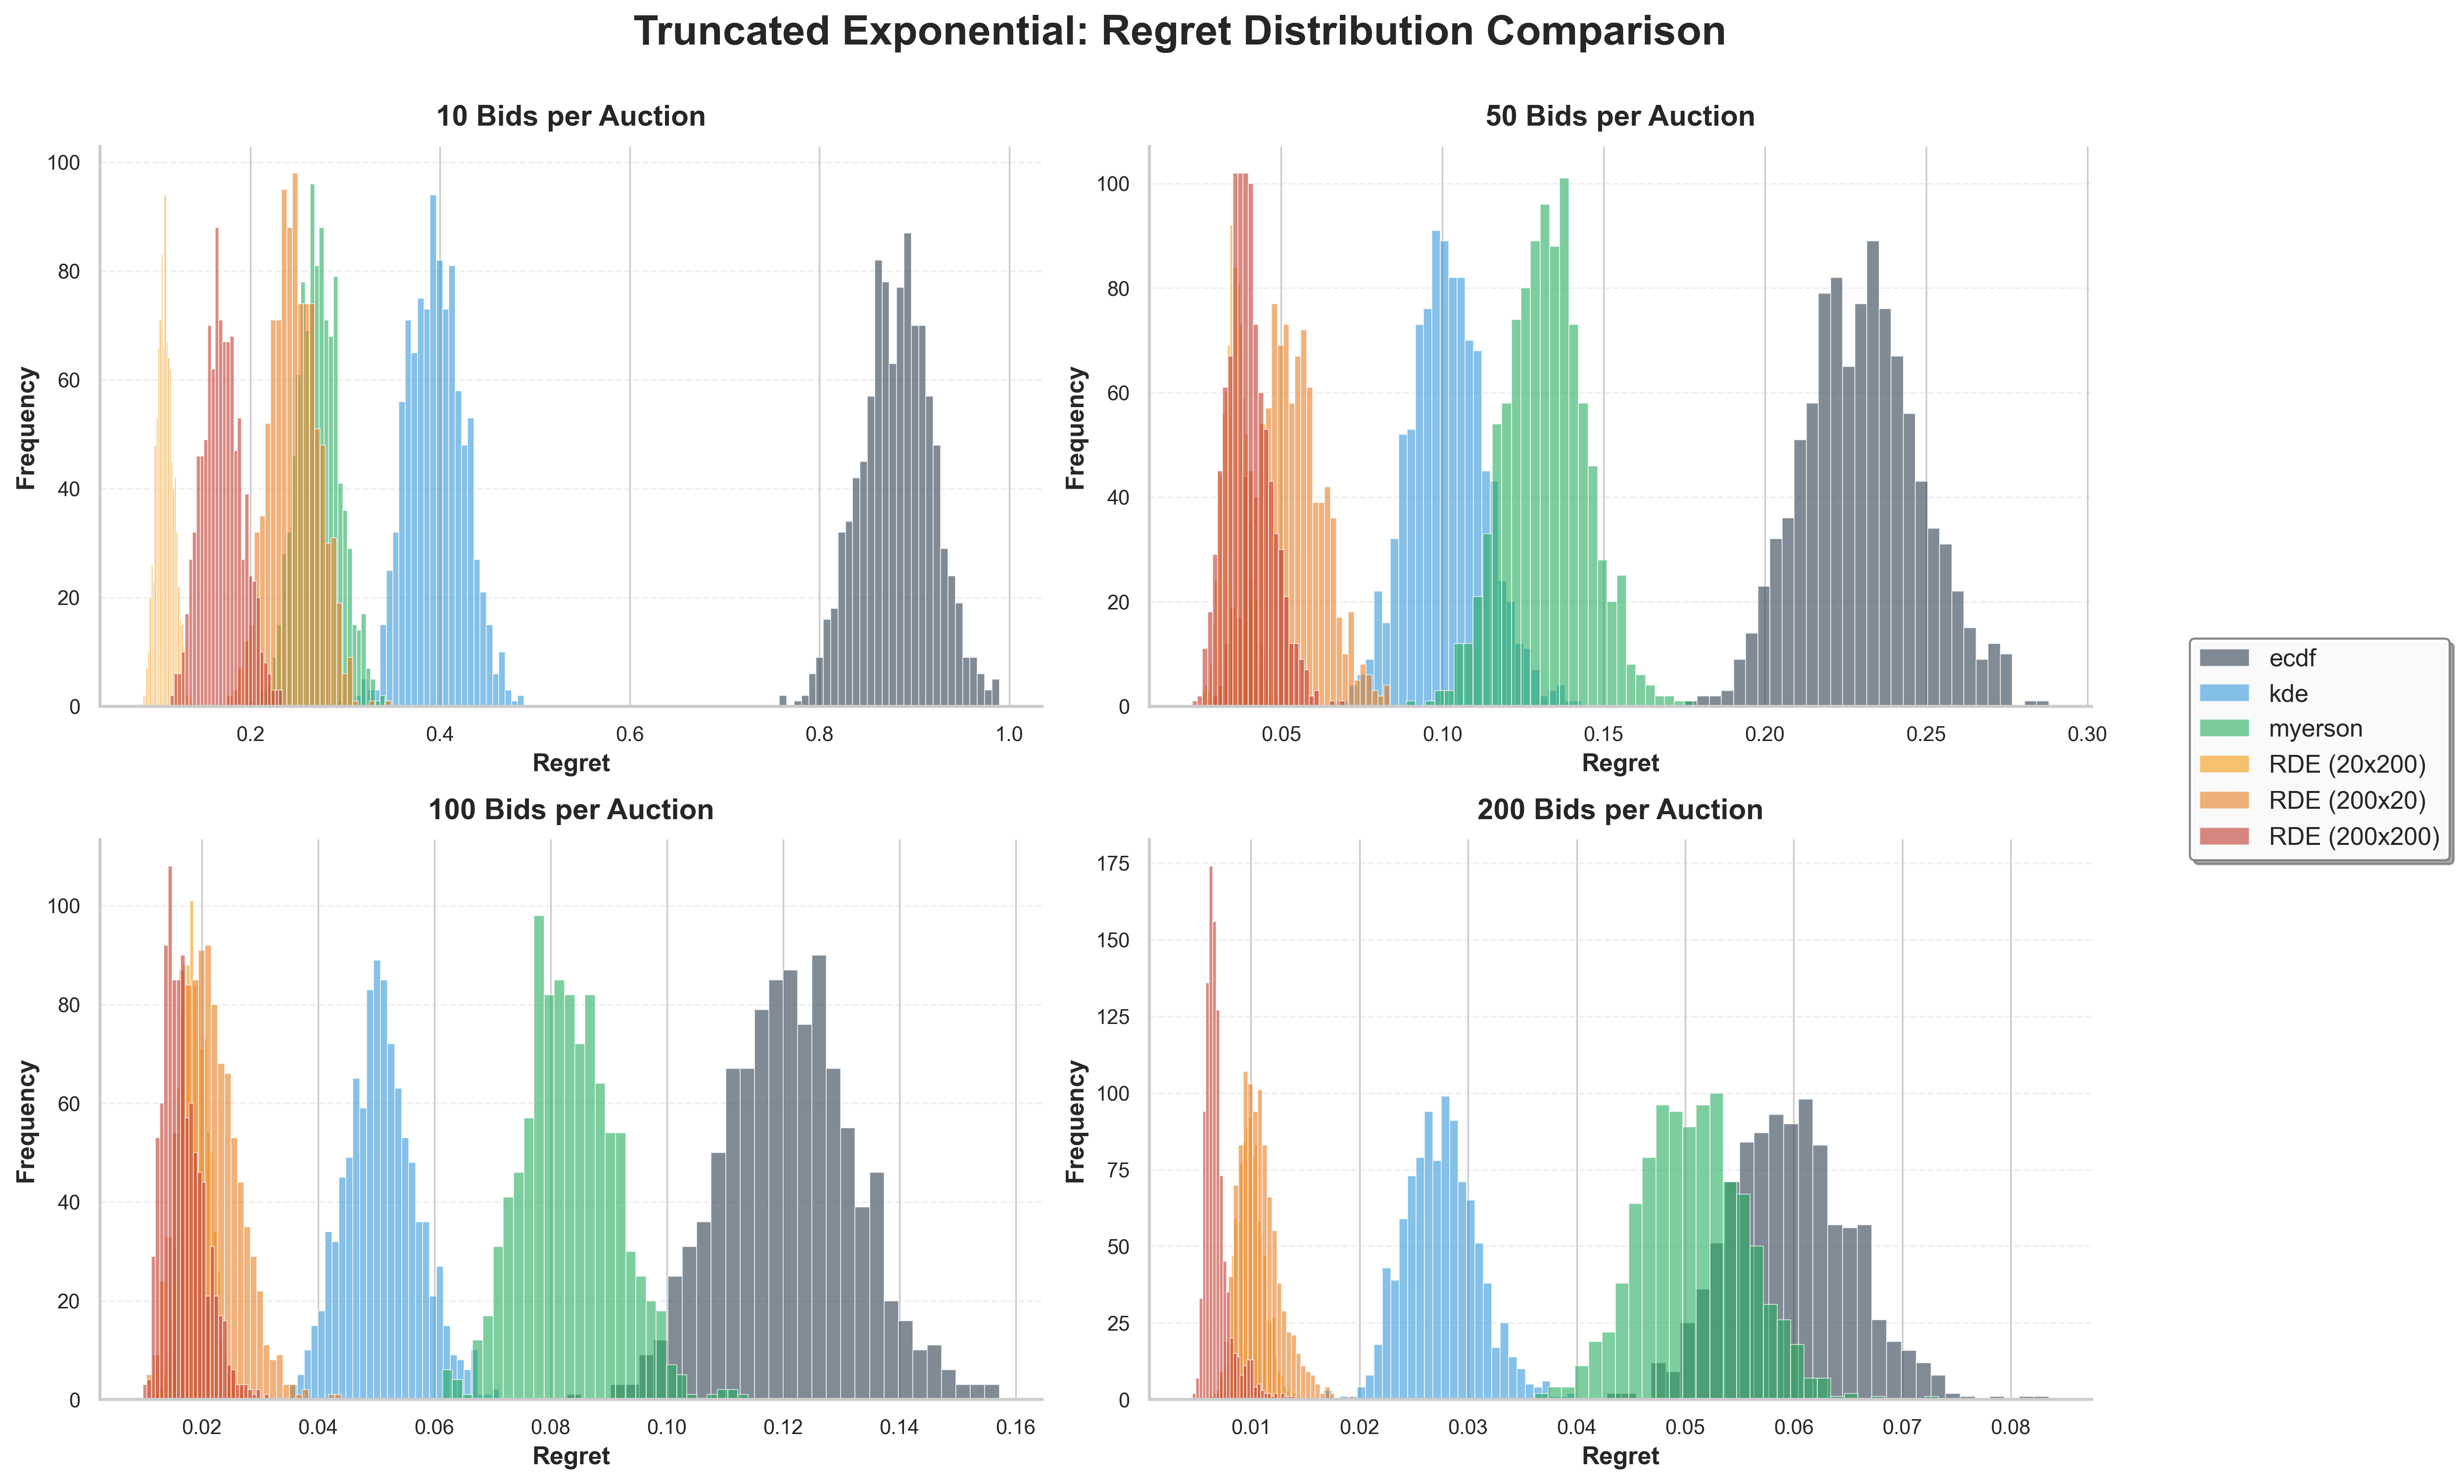

✅ Saved: histogram_beta_k2_no_myersonnet.png (4 subplots: 10, 50, 100, 200 bids)


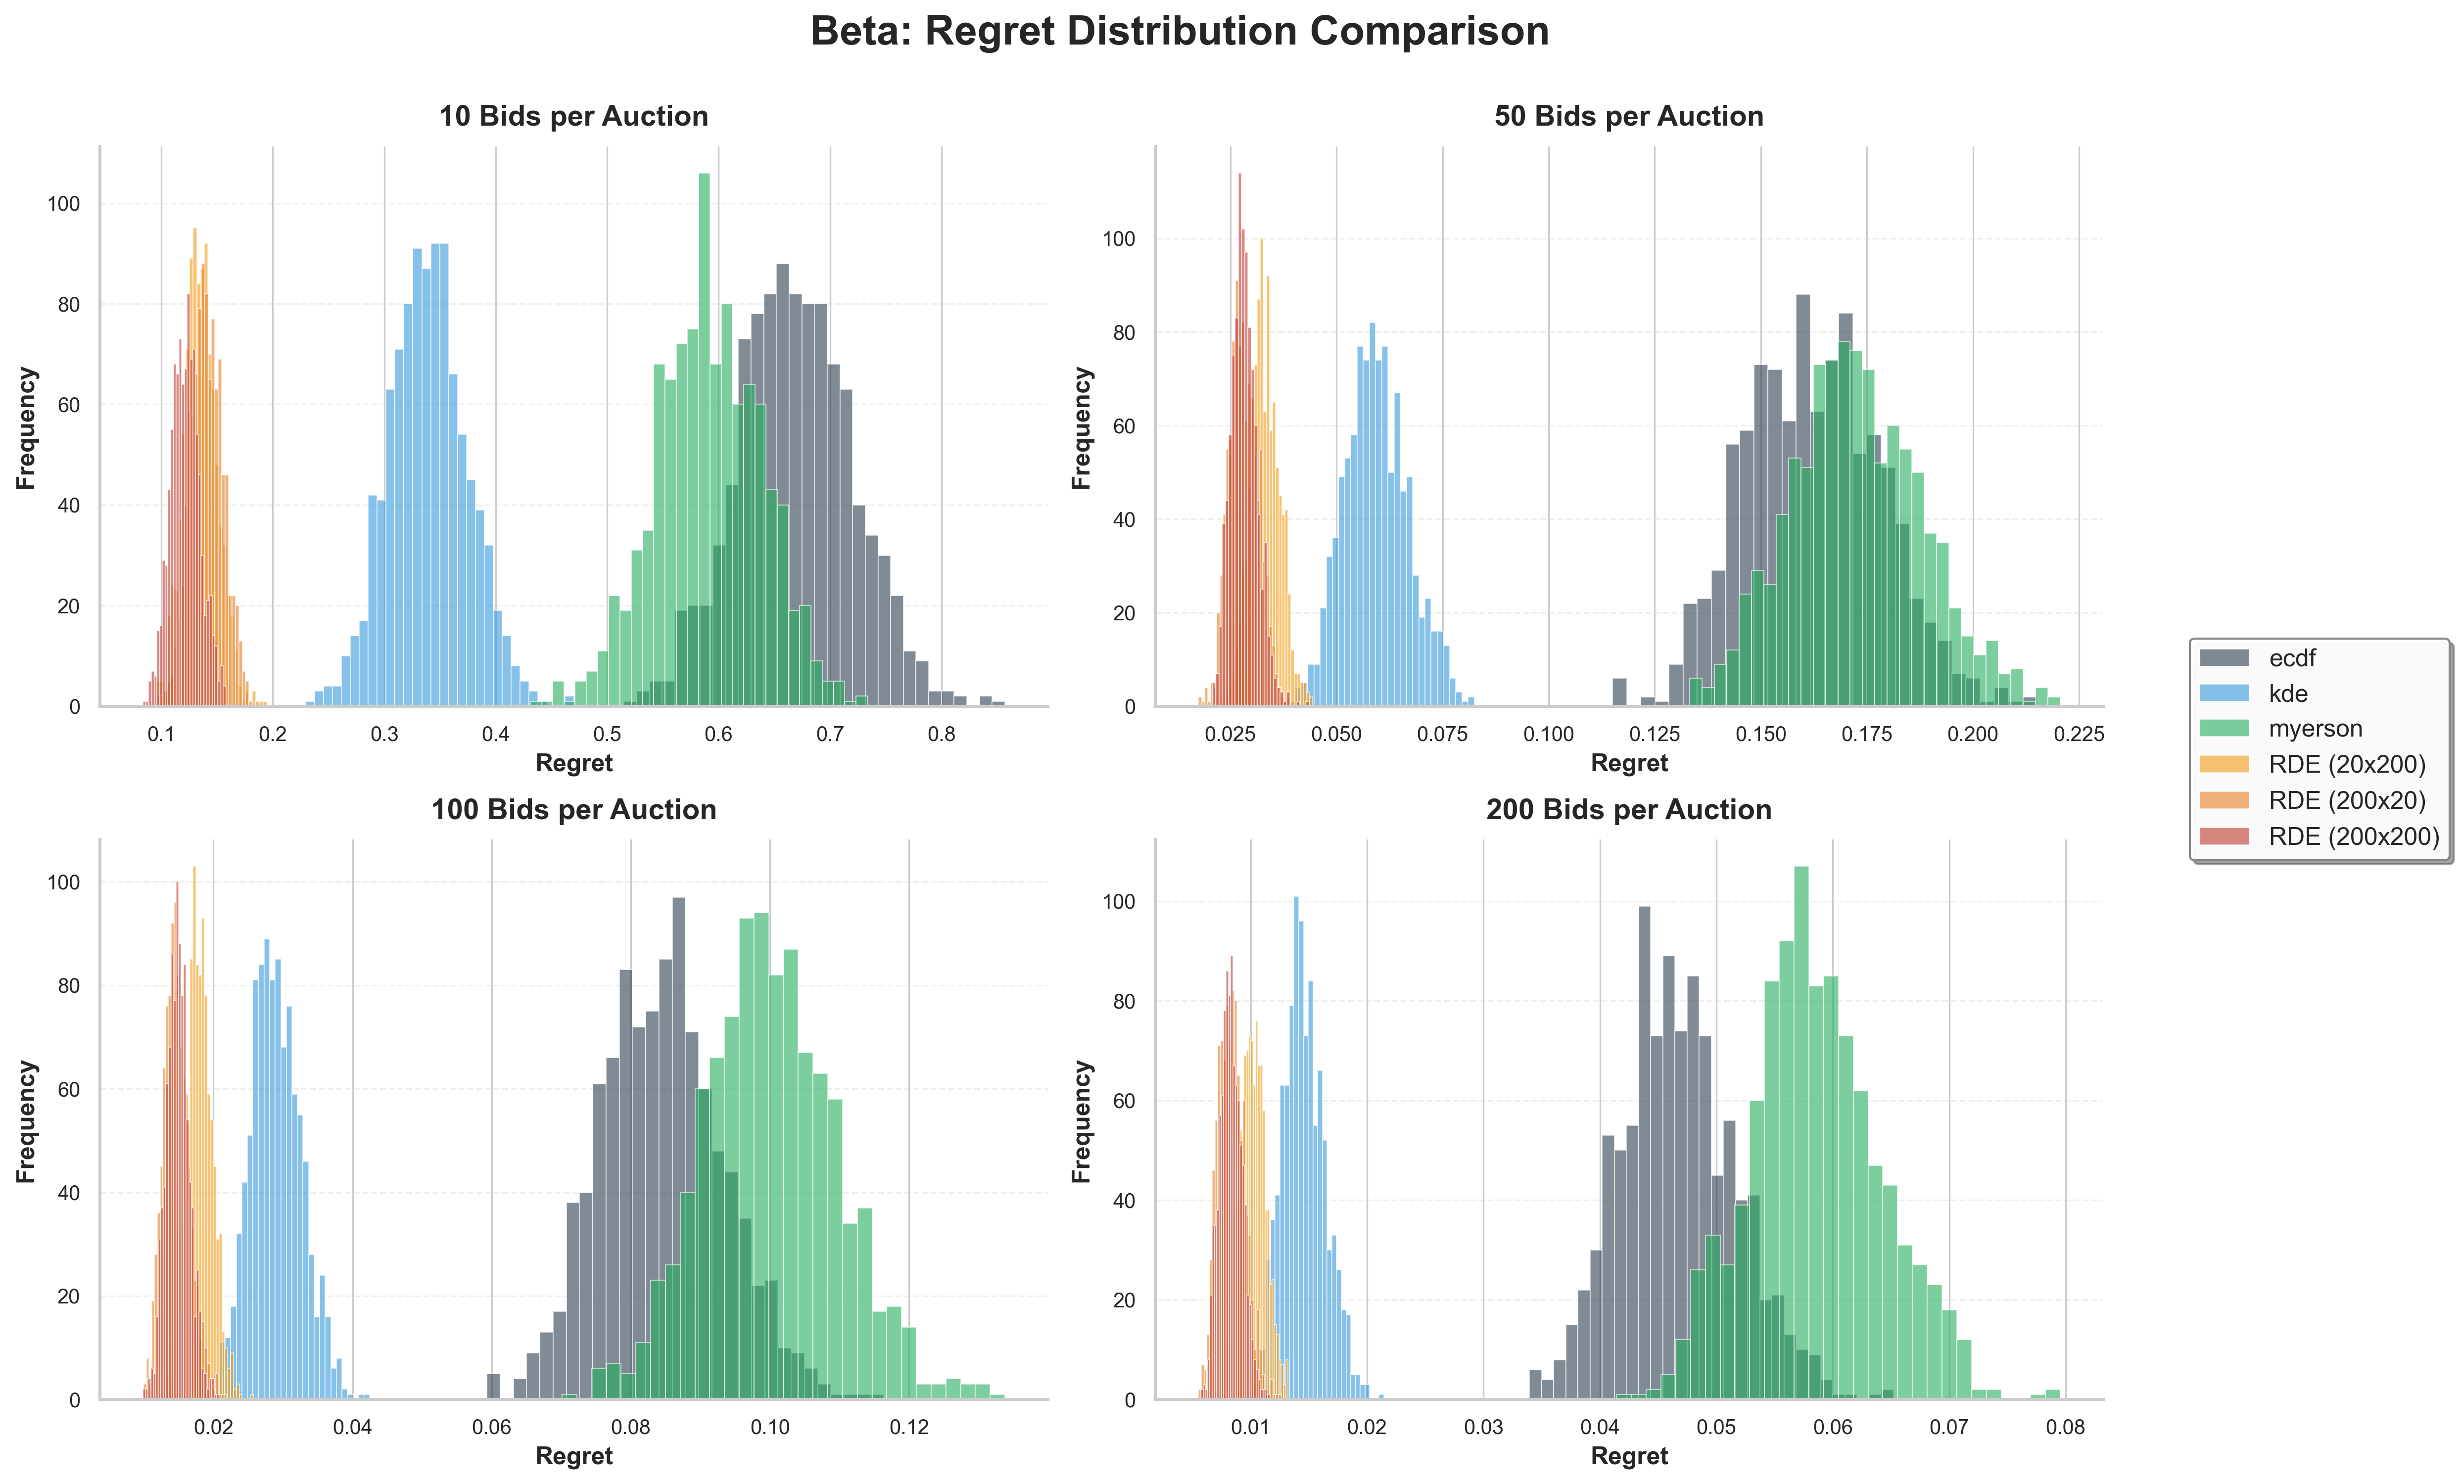

✅ Saved: histogram_truncpareto_k2_no_myersonnet.png (4 subplots: 10, 50, 100, 200 bids)


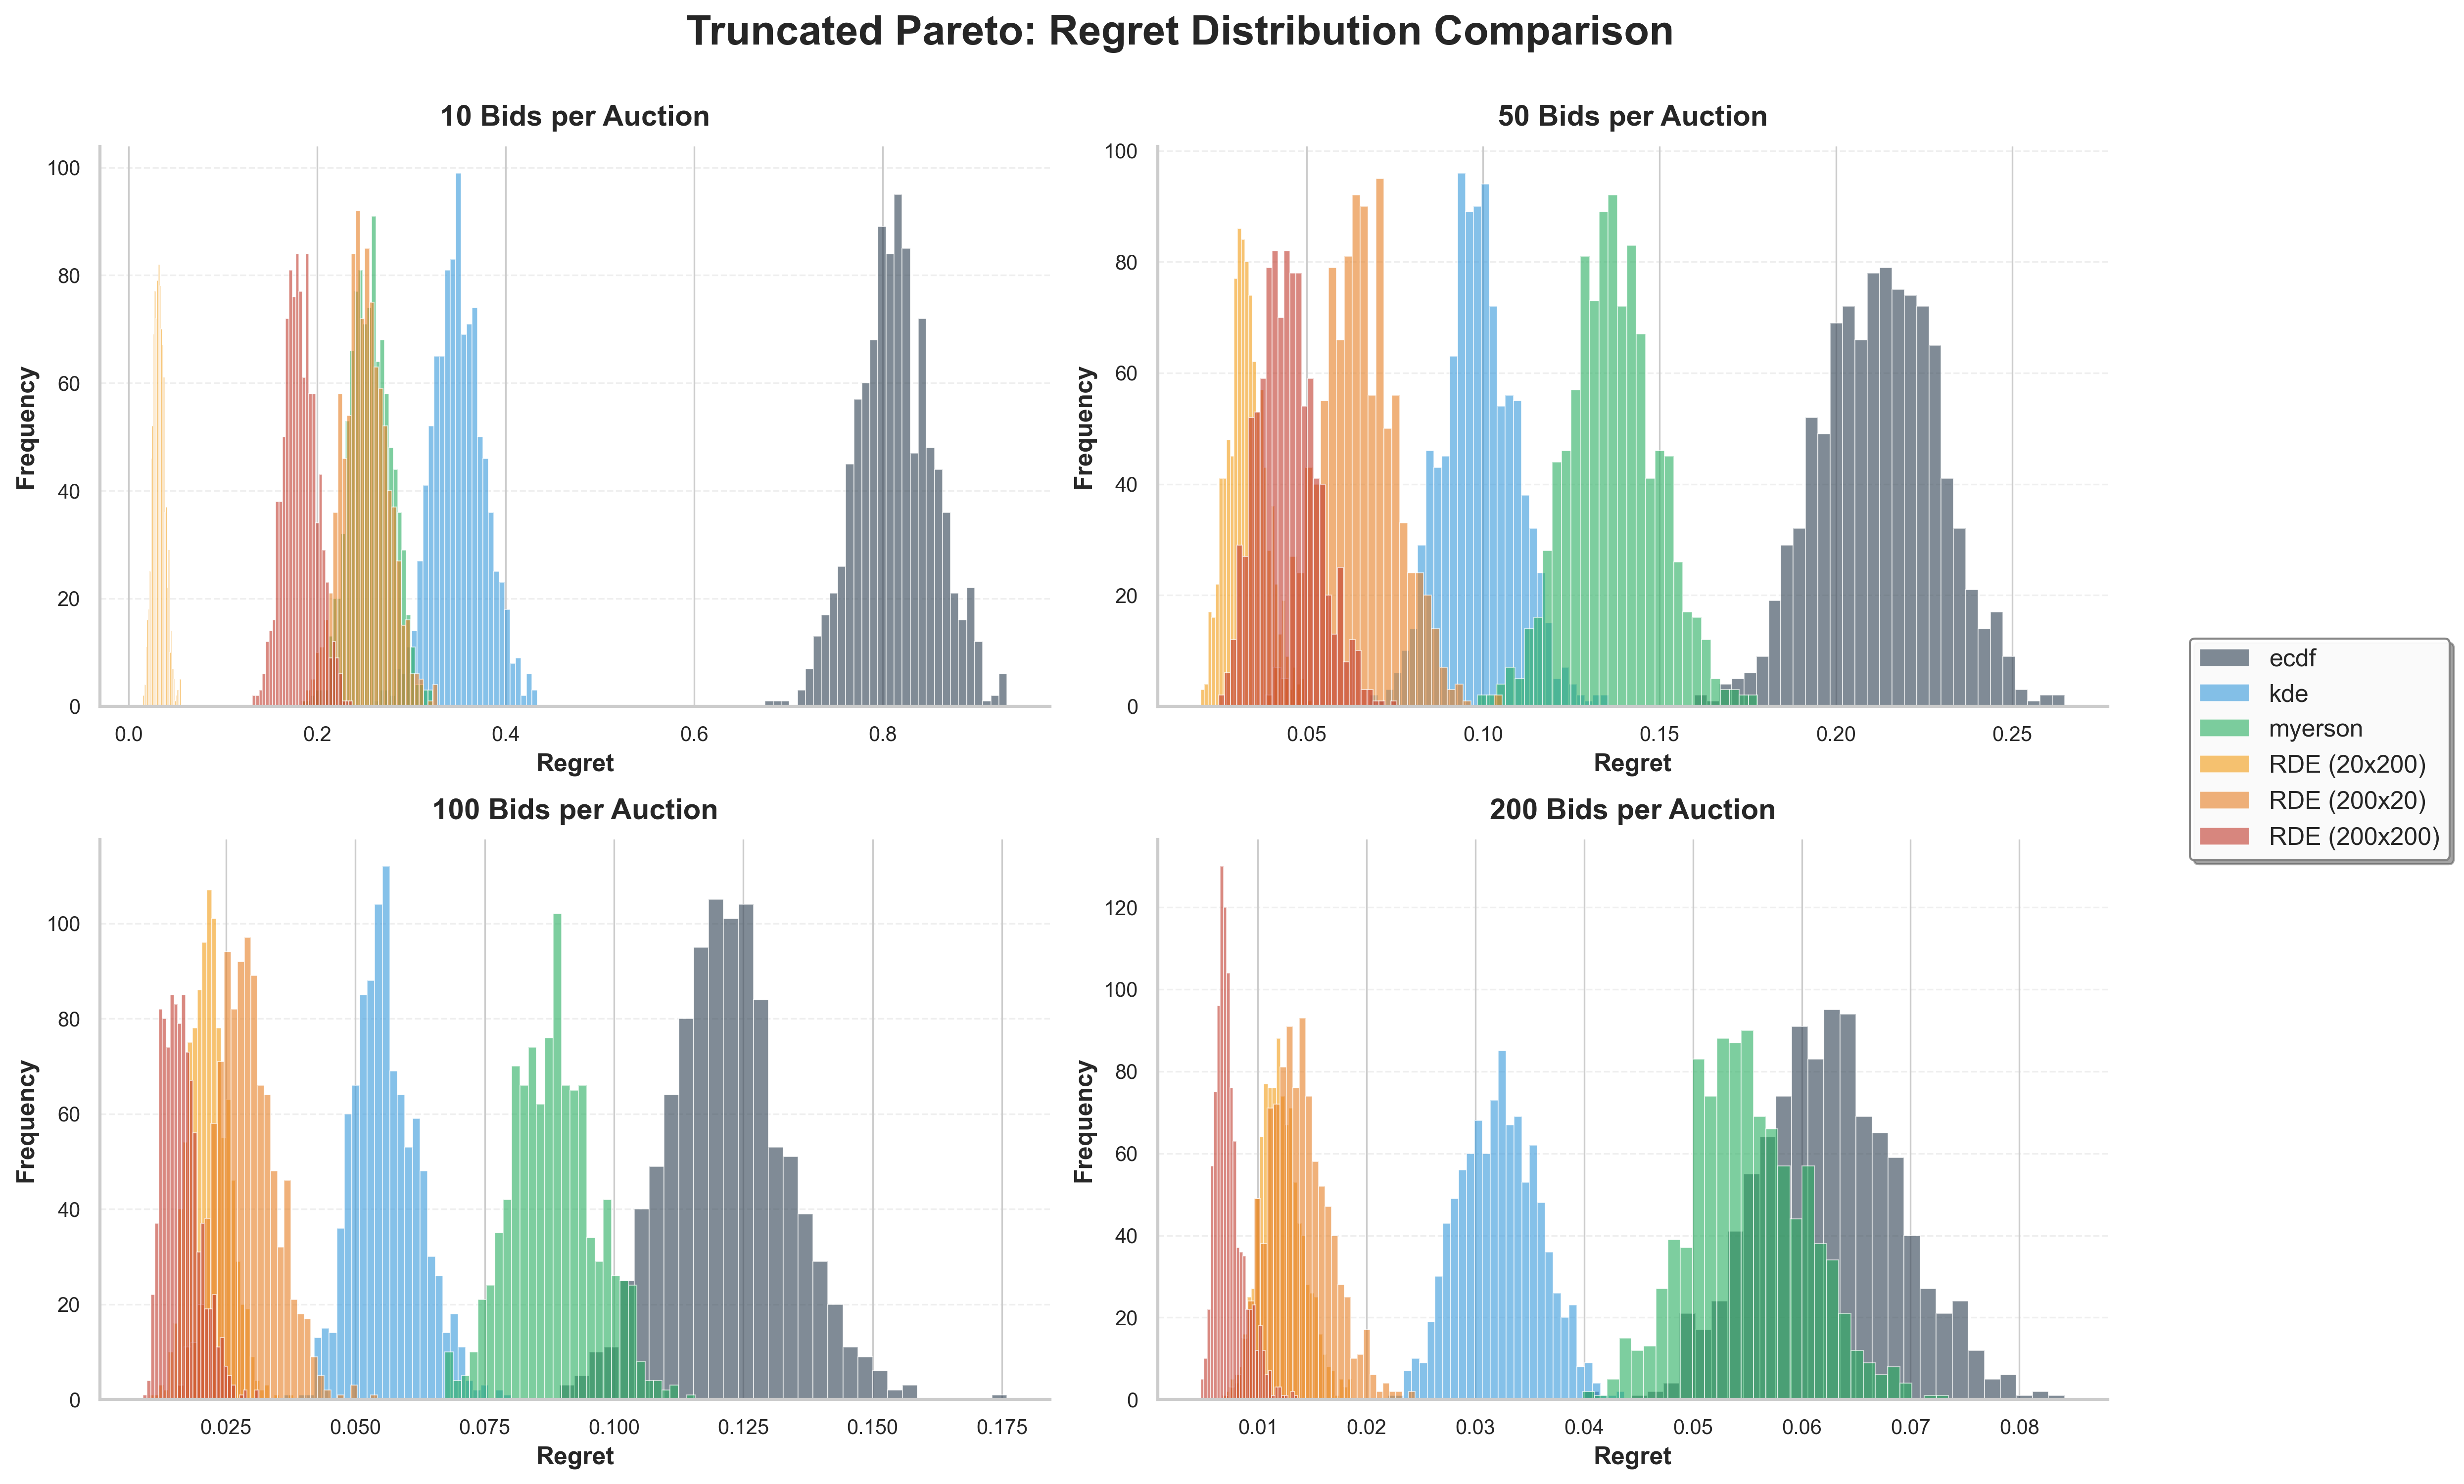

In [8]:
plot_regret_histograms(
    project_root=project_root,
    dist_names=DIST_NAMES,  # type: ignore
    bids_per_auction=BIDS_PER_AUCTION,  # [10, 50, 100, 200]
    k_fold=2,  # Use K=2 for histogram comparison
    methods=METHODS_WITHOUT_MYERSONNET,
    save_dir="workspace/plots/histograms",
    show=True,
    suffix="no_myersonnet",
)